In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import signal
from scipy.signal import butter, filtfilt, find_peaks, medfilt, sosfiltfilt
from sklearn import preprocessing
%matplotlib notebook

## Functions

In [2]:
#butterworth filter & filtering
def butter_filtering(sig,fs,fc,order,btype): 
    """
    sig: original signal
    fs: sampling frequency
    fc: cut off frequency
    order: order of filter
    btype: type of filter (highpass/lowpass/bandpass)
    
    return: filtered signal
    """
    w = np.array(fc)/(fs/2)
    b, a = butter(order, w, btype =btype, analog=False)
    filtered = filtfilt(b, a, sig)
    return(filtered)

In [3]:
def abp_sig(path_be, path_wav):
    df_test= pd.read_csv(path_be, delimiter = ';')
    df_wav = pd.read_csv(path_wav, delimiter = ';')
    cust_idx = df_test[df_test['Event']=='Custom1']["Time [s]"].to_list()#find the index
    
    abp = df_wav['Pressure [mmHg]'].values[int(cust_idx[0]*100):int(cust_idx[-1]*100)]
    plt.figure(figsize = (6,2))
    plt.plot(abp);plt.ylabel("Blood pressure(mmHg)");plt.xlabel("Sample")
    sbp_loc = find_peaks(abp, distance = 50, height = 80, width = 1, prominence = 1)[0]
    dbp_loc = find_peaks(-1*abp, distance = 50, height = -105, width = 2, prominence = 1)[0]
    plt.plot(sbp_loc, abp[sbp_loc], 'x', label = "SBP location")
    plt.plot(dbp_loc, abp[dbp_loc], 'o', label = "DBP location")
    plt.show()
    return abp


In [4]:
from biosppy.signals import ecg
import neurokit2 as nk
def ecg_ppg_show(path):
    df_sen = pd.read_csv(path, names = ['ts_ecg', 'ecg', 'ts_ppg', 'ppg'])
    
    ecg_sen = df_sen['ecg'].values[5:]
    ppg_sen = df_sen['ppg'].values[5:]

    ecg_f = butter_filtering(ecg_sen, 200, [0.1, 50], 5, 'bandpass')
    ppg_f = butter_filtering(ppg_sen, 200, [0.5, 10], 5, 'bandpass')

    from biosppy.signals import ecg
    ecg_feat = ecg.ecg(1*ecg_f, sampling_rate=200.0, show=True)
    ts = ecg_feat[0]
    filtered = ecg_feat[1]
    rpeaks = ecg_feat[2]
    templates_ts = ecg_feat[3]
    templates = ecg_feat[4]
    heart_rate_ts = ecg_feat[5]
    heart_rate = ecg_feat[6]

    import neurokit2 as nk
    info = nk.ppg_findpeaks(-1*ppg_f, sampling_rate=200, method='elgendi', show=True)
    
    return (ecg_f, ppg_f)

In [5]:
import scipy.stats as st
from sklearn.preprocessing import scale
#ppg features used as calibration
def ppg_features(ppg_f):
    ppg_fn = scale(ppg_f)
    ppg_d = np.gradient(-1*ppg_fn)
    ppg_dd = np.gradient(ppg_d)
    fs = 200
    
    ppg_maxamp = []
    ppg_std = []
    ppg_skew = []
    ppg_kurto = []

    ppg_aimean = []
    ppg_lasimean = []
    
    ppg_aistd = []
    ppg_lasistd=[]
    
    win = 3*200#3s time window
    step = 1*200#1s
    
    for i in range(0, len(ppg_f) - win, int(step)):
        st_idx = i
        end_idx = i+win
        #ppg maxamp
        maxamp = np.ptp(ppg_f[st_idx:end_idx])
        ppg_maxamp.append(maxamp)
        
        #ppg std
        std = np.std(ppg_f[st_idx:end_idx])
        ppg_std.append(std)
        
        #ppg skewness
        skew = st.skew(ppg_f[st_idx:end_idx])
        ppg_skew.append(skew)
        
        #ppg kurtosis
        kur = st.kurtosis(ppg_f[st_idx:end_idx])
        ppg_kurto.append(kur)
        
        #ppg peaks
        info = nk.ppg_findpeaks(-1*ppg_f[st_idx:end_idx], sampling_rate=200, method='elgendi', show=False)#pat-foot
        ppeaks = info['PPG_Peaks']
           
        #ai mean std
        #lasi mean std
        ai = []
        lasi = []
        for p in range(0, len(ppeaks)-1):
            y = ppg_f[st_idx:end_idx][ppeaks[p]]
            dias_peaks2 = find_peaks(ppg_dd[st_idx:end_idx][ppeaks[p]:ppeaks[p+1]], distance = 50, height = 0)[0]
            dias_peaks2+= ppeaks[p]
            dia_p = dias_peaks2[0]
            
            x=ppg_f[st_idx:end_idx][dia_p]
            
            ai.append(x/y)
            lasi.append((dia_p-ppeaks[p])/fs)
            
        ppg_aimean.append(np.mean(ai))
        ppg_lasimean.append(np.mean(lasi))
        
        ppg_aistd.append(np.std(ai))
        ppg_lasistd.append(np.std(lasi))
    return (ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd)


    

In [6]:
def ecg_features(ecg_f):
    win = 3*200#3s time window
    step = 1*200#1s    
    
    hr_lis = []
    
    for i in range(0, len(ecg_f) - win, int(step)):
        st_idx = i
        end_idx = i+win
        rpeaks = ecg.ecg(-1*ecg_f[st_idx:end_idx], sampling_rate=200.0, show=False)[2]
        
        #Use ecg to ectract HR feature
        if i==0:
            start_time = rpeaks[0]/200
        intervals = np.diff(rpeaks)/200
        hr = 60/np.mean(intervals)
        hr_lis.append(hr)
        
    return hr_lis

In [7]:
def pat_features(ecg_f, ppg_f):
    
    win = 3*200#3s time window
    step = 1*200#1s 
    
    ppg_d = np.gradient(-1*ppg_f)
    ppg_dd = np.gradient(ppg_d)
    
    pat_mx=[]
    pat_pk=[]
    pat_ft=[]
    
    for i in range(0, len(ecg_f) - win, int(step)):
        st_idx = i
        end_idx = i+win
        rpeaks = ecg.ecg(-1*ecg_f[st_idx:end_idx], sampling_rate=200.0, show=False)[2]
        
        #pat rpeak to ppg_peak
        info = nk.ppg_findpeaks(-1*ppg_f[st_idx:end_idx], sampling_rate=200, method='elgendi', show=False)
        ppeaks = info['PPG_Peaks']
        
        cor = np.where(ppeaks>=rpeaks[0])
        ppeaks_cor = ppeaks[cor]
    
        maxlen = min(len(ppeaks_cor),len(rpeaks) )
        pk = np.mean((ppeaks_cor[:maxlen] - rpeaks[:maxlen])/200)
        pat_pk.append(pk)
        
        #maximum slope
        maxsl = find_peaks(ppg_d[st_idx:end_idx], distance = 50, height = 10, width = 2, prominence = 1)[0]
        #pat rpeak to maximum slope
        cor2 = np.where(maxsl>=rpeaks[0])
        maxsl_cor = maxsl[cor2]
        
        maxlen = min(len(maxsl_cor),len(rpeaks) )
        ms = np.mean((maxsl_cor[:maxlen] - rpeaks[:maxlen])/200)
        pat_mx.append(ms)
        
        #foot
        info2 = nk.ppg_findpeaks(ppg_f[st_idx:end_idx], sampling_rate=200, method='elgendi', show=False)#pat-foot
        pfoot = info2['PPG_Peaks']
        #pat rpeak to ppg_foot 
        cor3 = np.where(pfoot>=rpeaks[0])
        pfoot_cor = pfoot[cor3]
    
        maxlen = min(len(pfoot_cor),len(rpeaks) )
        ft = np.mean((pfoot_cor[:maxlen] - rpeaks[:maxlen])/200)
        pat_ft.append(ft)    
    return (pat_mx, pat_pk, pat_ft)
    


In [8]:
def sbp_dbp(abp):
    win_bp = 3*100 #3s
    step_bp = 1*100
    sbp_lis = []
    dbp_lis = []

    for i in range(0, len(abp)-win_bp, int(step_bp)):
        st_idx = i
        end_idx = i+win_bp
        
        sbp_loc = find_peaks(abp[st_idx:end_idx],  distance = 50, height = 75, width = 1,prominence=1)[0]
        sbp_mean = np.mean(abp[st_idx:end_idx][sbp_loc])
        sbp_lis.append(sbp_mean)
    
        dbp_loc = find_peaks(-1*abp[st_idx:end_idx], distance = 50, height = -105, width = 2, prominence = 1)[0]
        dbp_mean = np.mean(abp[st_idx:end_idx][dbp_loc])
        dbp_lis.append(dbp_mean)
    return (sbp_lis, dbp_lis)

In [40]:
def visualize(ecg_f, hr_lis, pat_lis, sbp_lis, dbp_lis):#pat_foot
    rpeaks = ecg.ecg(-1*ecg_f, sampling_rate=200.0, show=False)[2]
    start_time = rpeaks[0]/200
    
    ts_hr = np.linspace(3/200+start_time,start_time+ 3/200+1*len(hr_lis), len(hr_lis))
    ts_pat = np.linspace(start_time +3/200, start_time+3/200+1*len(pat_lis), len(pat_lis))
    ts_sbp = np.linspace(0,1*len(sbp_lis), len(sbp_lis) )
    ts_dbp = np.linspace(0,1*len(dbp_lis), len(dbp_lis))
    fig, axs = plt.subplots(4,1,figsize = (6,6), constrained_layout = True)
    ax = axs[0]

    ax.plot(ts_hr, hr_lis, label = "heart rate")
    ax.set_xlabel('time(s)');ax.set_ylabel('HR (bpm)')
    ax.legend()

    ax = axs[1]
    ax.plot(ts_pat, pat_lis, label = "PAT")
    #ax.axvline(x= 10, ls = ':', c = 'g', label = 'start')
    #ax.axvline(x= , ls = '--', c = 'r', label = 'end')
    ax.set_xlabel('time(s)'); ax.set_ylabel('PAT (s)')
    ax.legend()

    ax = axs[2]
    ax.plot(ts_sbp,sbp_lis, label = 'SBP')
    ax.set_xlabel('time(s)'); ax.set_ylabel('BP (mmHg)')
    ax.legend()

    ax= axs[3]
    ax.plot(ts_dbp, dbp_lis, label = 'DBP')
    ax.set_xlabel('time(s)'); ax.set_ylabel('BP (mmHg)')
    ax.legend()    


In [ ]:
def features(ppg_f, ecg_f, abp):
    #200Hz 5s window = 1000samples
#2.5s overlapping step = 500samples
#calculate HR and PATpeak on each 5-second window

    win = 3*200#5s-->3s
    step = 1*200#1s

    hr_lis = []
    pat_lis = []
    sbp_lis = []
    dbp_lis = []

    for i in range(0, len(ecg_f) - win, int(step)):
        st_idx = i
        end_idx = i+win
        rpeaks = ecg.ecg(-1*ecg_f[st_idx:end_idx], sampling_rate=200.0, show=False)[2]
        
        #Use ecg to ectract HR feature
        if i==0:
            start_time = rpeaks[0]/200
        intervals = np.diff(rpeaks)/200
        hr = 60/np.mean(intervals)
        hr_lis.append(hr)
        
        #PAT-foot
        info = nk.ppg_findpeaks(ppg_f[st_idx:end_idx], sampling_rate=200, method='elgendi', show=False)#pat-foot
        ppeaks = info['PPG_Peaks']
        #ppeaks = find_peaks(ppg_f[st_idx:end_idx],  distance = 50, width = 1,prominence=1)[0]
    
        cor = np.where(ppeaks>=rpeaks[0])
        ppeaks_cor = ppeaks[cor]
    
        maxlen = min(len(ppeaks_cor),len(rpeaks) )
        pat = np.mean((ppeaks_cor[:maxlen] - rpeaks[:maxlen])/200)
        pat_lis.append(pat)
    
    win_bp = 3*100 #3s
    step_bp = 1*100

    for i in range(0, len(abp)-win_bp, int(step_bp)):
        st_idx = i
        end_idx = i+win_bp
        sbp_loc = find_peaks(abp[st_idx:end_idx],  distance = 50, height = 75, width = 1,prominence=1)[0]
        sbp_mean = np.mean(abp[st_idx:end_idx][sbp_loc])
        sbp_lis.append(sbp_mean)
    
        dbp_loc = find_peaks(-1*abp[st_idx:end_idx], distance = 50, height = -105, width = 2, prominence = 1)[0]
        dbp_mean = np.mean(abp[st_idx:end_idx][dbp_loc])
        dbp_lis.append(dbp_mean)
    print(len(hr_lis), len(sbp_lis))
    
    ts_hr = np.linspace(5/200+start_time,start_time+ 5/200+2.5*len(hr_lis), len(hr_lis))
    ts_pat = np.linspace(start_time +5/200, start_time+5/200+2.5*len(pat_lis), len(pat_lis))
    ts_sbp = np.linspace(0,2.5*len(sbp_lis), len(sbp_lis) )
    ts_dbp = np.linspace(0,2.5*len(dbp_lis), len(dbp_lis))
    fig, axs = plt.subplots(4,1,figsize = (6,4), constrained_layout = True)
    ax = axs[0]
    #ax.set_title('valsalva maneuver 10s')
    ax.plot(ts_hr, hr_lis, label = "heart rate")
    ax.set_xlabel('time(s)');ax.set_ylabel('heart rate (bpm)')
    ax.legend()

    ax = axs[1]
    ax.plot(ts_pat, pat_lis, label = "PAT")
    #ax.axvline(x= 10, ls = ':', c = 'g', label = 'start')
    #ax.axvline(x= , ls = '--', c = 'r', label = 'end')
    ax.set_xlabel('time(s)'); ax.set_ylabel('PAT (s)')
    ax.legend()

    ax = axs[2]
    ax.plot(ts_sbp,sbp_lis, label = 'SBP')
    ax.set_xlabel('time(s)'); ax.set_ylabel('BP (mmHg)')
    ax.legend()

    ax= axs[3]
    ax.plot(ts_dbp, dbp_lis, label = 'DBP')
    ax.set_xlabel('time(s)'); ax.set_ylabel('BP (mmHg)')
    ax.legend()
    
    return (hr_lis, pat_lis, sbp_lis, dbp_lis)

In [10]:
import os
def filename_lis(path_fo, name):
    filename = []
    lis = os.listdir(path_fo)
    for f in lis:
        if name in f:
            filename.append(f)
    return filename

In [11]:
def findfiles(files_path, files_list, name):
    
    files = os.listdir(files_path)
    for s in files:
        s_path = os.path.join(files_path, s)
        if os.path.isdir(s_path):
            findfiles(s_path, files_list, name)
        elif os.path.isfile(s_path) and name in s:
            result.append(s_path)

## Load data

In [41]:
#1828
path_wav =  '../carlos_ref_29/2022-02-09-17-33-33/CNAP_2022-02-09_18-28-57_001_waveform.csv'
path_bet =  '../carlos_ref_29/2022-02-09-17-33-33/CNAP_2022-02-09_18-28-57_001_beats.csv'
path_sen = '../carlos_ref_29/2022-02-09-17-33-33/2022-02-09-17-33-33.csv'

<IPython.core.display.Javascript object>


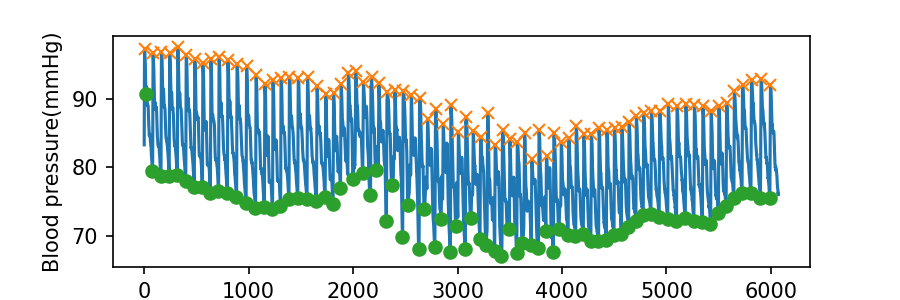

In [42]:
abp = abp_sig(path_bet, path_wav)

<IPython.core.display.Javascript object>


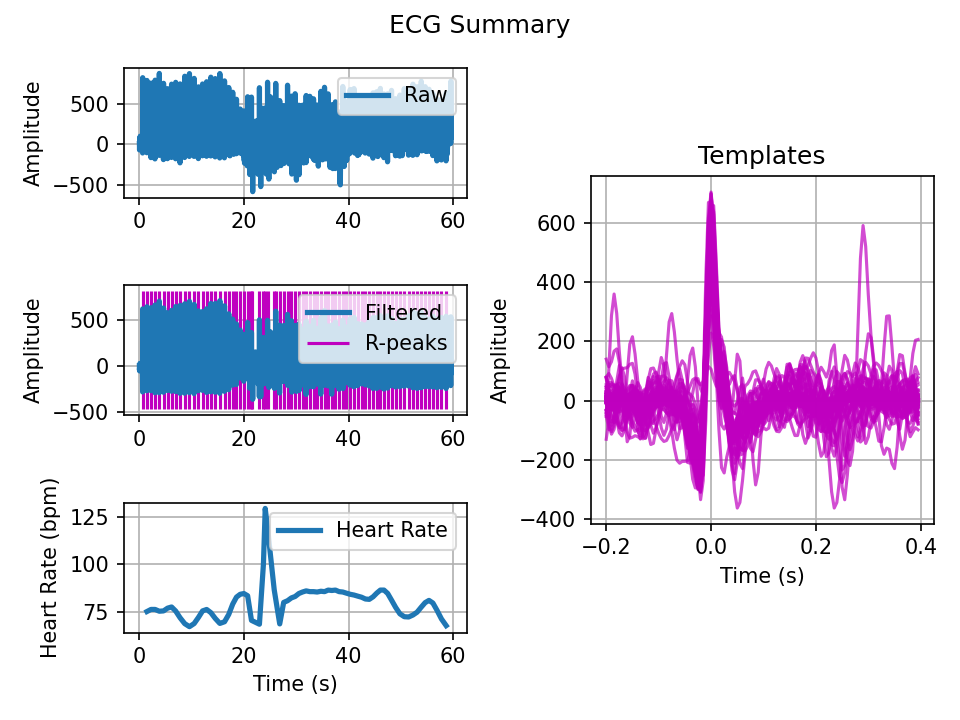

<IPython.core.display.Javascript object>


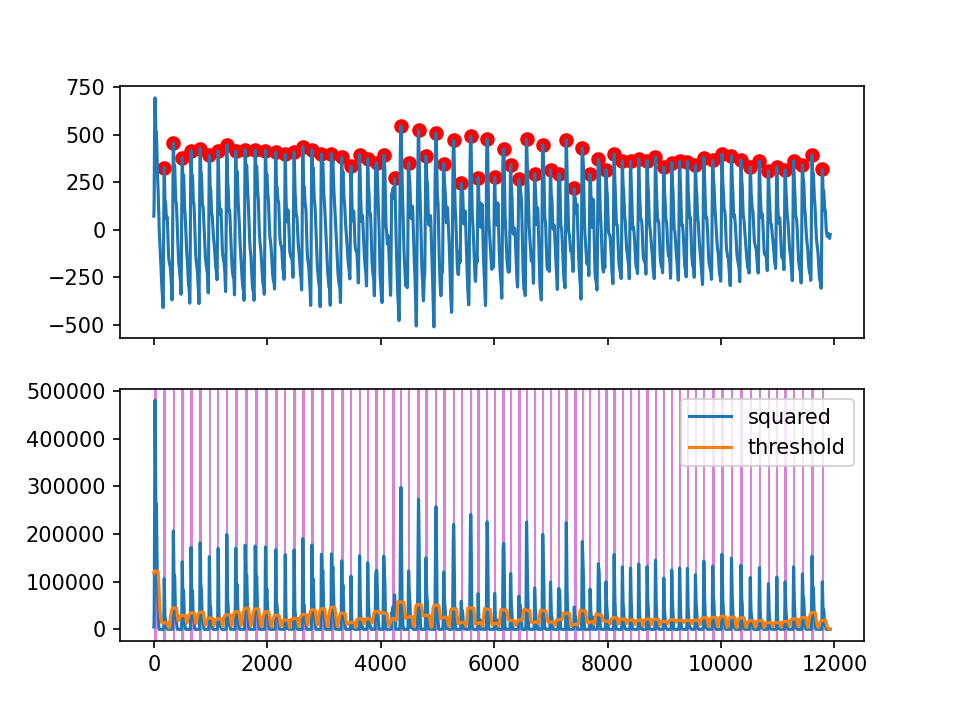

In [43]:
ecg_f, ppg_f = ecg_ppg_show(path_sen)

In [44]:
ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd = ppg_features(ppg_f)

In [45]:
hr_lis = ecg_features(ecg_f)
#print(hr_lis)
#print(len(hr_lis))

<IPython.core.display.Javascript object>


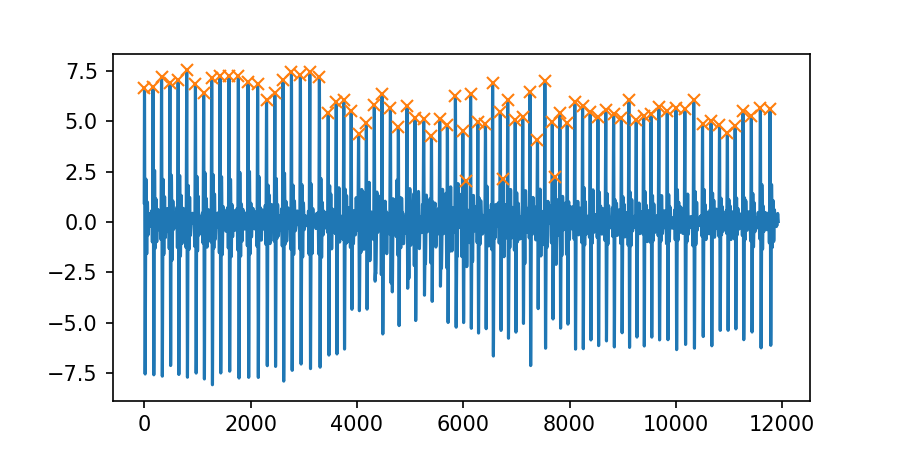

In [46]:
ppg_fn = scale(ppg_f)
ppg_d = np.gradient(-1*ppg_f)
ppg_dd = np.gradient(ppg_d)
s = find_peaks(ppg_dd, distance = 50, height = 2, width = 2, prominence = 1)[0]
plt.figure(figsize = (6,3))
#plt.plot(-1*ppg_f)
plt.plot(ppg_dd)
plt.plot(s, ppg_dd[s], 'x')

In [47]:
pat_mx, pat_pk, pat_ft = pat_features(ecg_f, ppg_f)

In [48]:
sbp_lis, dbp_lis = sbp_dbp(abp)

In [20]:
len(dbp_lis)

58

In [21]:
len(pat_ft)

57

<IPython.core.display.Javascript object>


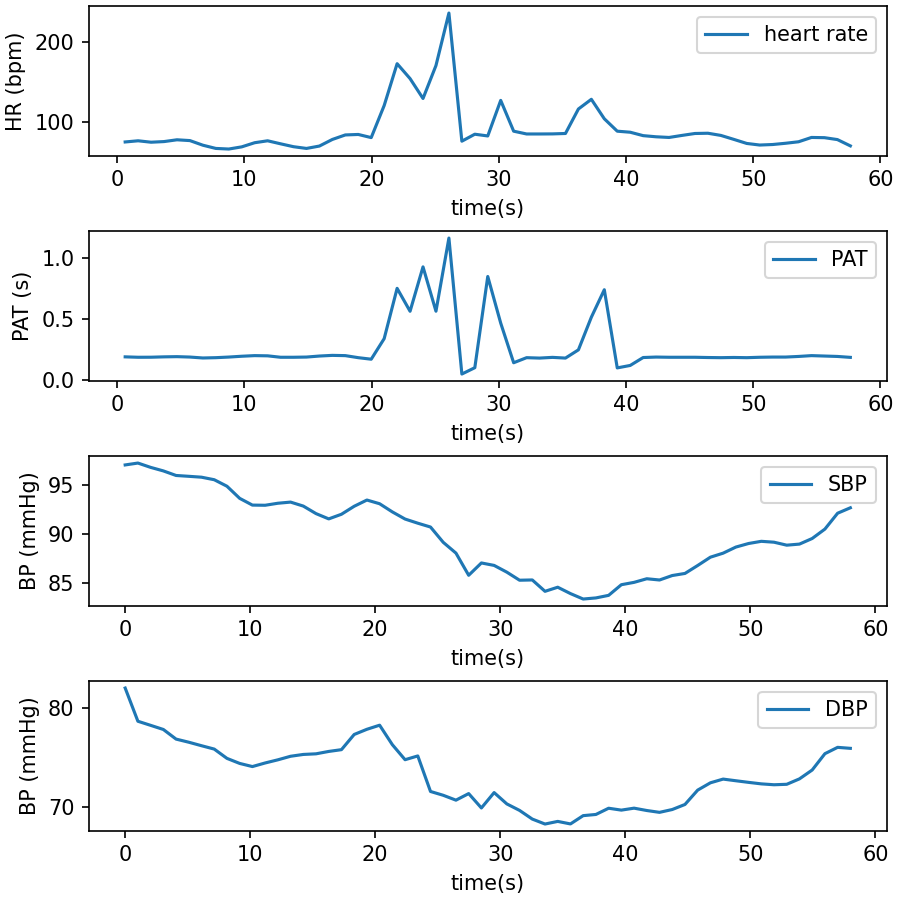

In [49]:
visualize(ecg_f, hr_lis, pat_ft, sbp_lis, dbp_lis)

In [24]:
df_1828 = pd.DataFrame({'mxamp':ppg_maxamp, 'std':ppg_std, 'skew':ppg_skew, 'kurtosis':ppg_kurto, 'aimean':ppg_aimean, 'lasimean':ppg_lasimean, 'aistd':ppg_aistd, 'lasistd':ppg_lasistd,'hr':hr_lis, 'patmx':pat_mx, 'patpk':pat_pk, 'patft':pat_ft, 'sbp':sbp_lis[-57:], 'dbp':dbp_lis[-57:]})
df_1828

mxamp         std      skew  kurtosis    aimean  lasimean     aistd  \
0   1103.678125  257.960882 -0.337446 -0.700816  0.624812  0.055000  0.121706   
1    843.955510  226.727166 -0.232587 -1.148303  0.725497  0.052500  0.021020   
2    816.011367  227.834108 -0.194257 -1.250072  0.685531  0.052500  0.018946   
3    816.011367  219.478420 -0.094774 -1.124692  0.681572  0.055000  0.054241   
4    779.323156  201.722963 -0.273367 -0.983236  0.570285  0.057500  0.057045   
5    818.692872  207.727923 -0.328586 -0.910390  0.563377  0.057500  0.050137   
6    818.883053  238.201147 -0.319364 -1.228372  0.655906  0.055000  0.042392   
7    793.081715  250.223818 -0.107825 -1.461211  0.732413  0.055000  0.000000   
8    793.081715  236.147799  0.019936 -1.386396  0.684562  0.055000  0.022567   
9    756.135354  204.040865 -0.121186 -1.115376  0.634658  0.057500  0.027337   
10   721.828342  182.693261 -0.402994 -0.770687  0.531294  0.062500  0.076027   
11   835.700291  199.376952 -0.431001 -0.681220  0.512227  0.062500  0.056959   
12   841.899426  232.432677 -0.181376 -1.239660  0.635886  0.058333  0.092447   
13   841.899426  249.798147  0.063677 -1.382357  0.787260  0.055000  0.020643   
14   803.585363  241.291611  0.065065 -1.345318  0.811916  0.052500  0.004013   
15   796.232113  210.018500 -0.197889 -1.010310  0.779733  0.052500  0.036197   
16   777.519618  197.397008 -0.242878 -0.975261  0.459884  0.093333  0.260034   
17   741.664765  197.593267 -0.296244 -1.041934  0.433402  0.093333  0.232372   
18   777.190730  224.046633 -0.133480 -1.157649  0.654495  0.072500  0.009596   
19  1024.717278  252.079358 -0.028316 -1.032163  0.266139  0.128333  0.269010   
20  1024.717278  245.859125 -0.066041 -0.939951  0.249574  0.105000  0.203719   
21  1053.149800  267.981344 -0.075955 -1.034280  0.339356  0.147500  0.113937   
22  1034.802910  262.069744 -0.074979 -0.950692  0.515175  0.110000  0.212060   
23  1034.802910  263.356821  0.037444 -0.961625  0.580471  0.078333  0.125127   
24  1019.822152  245.581264 -0.045688 -0.814043  0.262980  0.167500  0.158327   
25   926.898520  234.255380 -0.149422 -0.832027  0.241175  0.170000  0.136522   
26   926.898520  222.078361 -0.186356 -0.592927  0.474008  0.090000  0.240464   
27   891.194463  215.561796 -0.305654 -0.495420  0.140727  0.172500  0.098988   
28   875.283051  210.713410 -0.276569 -0.649429  0.098004  0.190000  0.054861   
29   875.283051  212.714326 -0.487379 -0.577256  0.164346  0.151667  0.065932   
30   835.720203  220.669303 -0.124011 -1.062867  0.561742  0.073333  0.227614   
31   821.974073  197.230346 -0.265131 -0.873420  0.532487  0.100000  0.268888   
32   845.193041  224.341165 -0.225759 -1.058288  0.120479  0.187500  0.032523   
33   816.927188  194.034315 -0.209965 -0.761092  0.307658  0.135000  0.239932   
34   843.946974  210.838808 -0.447849 -0.738175  0.428289  0.112500  0.213159   
35   839.749397  202.005238 -0.228823 -0.786018  0.209145  0.176667  0.151919   
36   839.749397  201.537987 -0.438861 -0.706330  0.173510  0.185000  0.158722   
37   795.625047  206.908270 -0.149103 -1.122236  0.075438  0.192500  0.032788   
38   714.547463  187.876264 -0.358662 -0.938799  0.367565  0.131667  0.290193   
39   714.547463  193.699857 -0.401158 -1.000031  0.424448  0.120000  0.322693   
40   680.851119  178.912056 -0.399313 -0.831253  0.273388  0.140000  0.284254   
41   629.326382  177.145110 -0.492734 -0.899270  0.448601  0.095000  0.286452   
42   638.860052  179.937254 -0.444709 -0.957077  0.665996  0.055000  0.038604   
43   638.860052  172.264764 -0.476324 -0.865320  0.672483  0.056667  0.025442   
44   647.348629  177.843518 -0.459729 -0.894789  0.678905  0.055000  0.036526   
45   625.197539  175.082418 -0.250414 -1.047971  0.479322  0.096667  0.281155   
46   668.239113  181.123329 -0.390681 -0.963501  0.487213  0.096667  0.287922   
47   668.239113  187.284950 -0.327850 -1.092695  0.475291  0.107500  0.263811   
48   691.585786  195.723397 -0.461998 -0.

In [ ]:
df_1828.to_csv("../c_prepared_data/1828_all.csv", index = False)

<IPython.core.display.Javascript object>


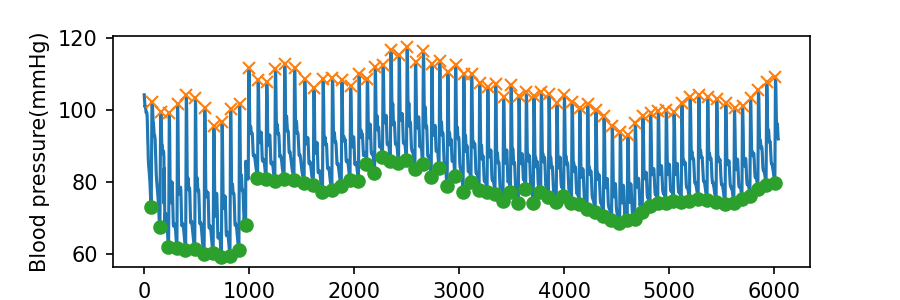

<IPython.core.display.Javascript object>


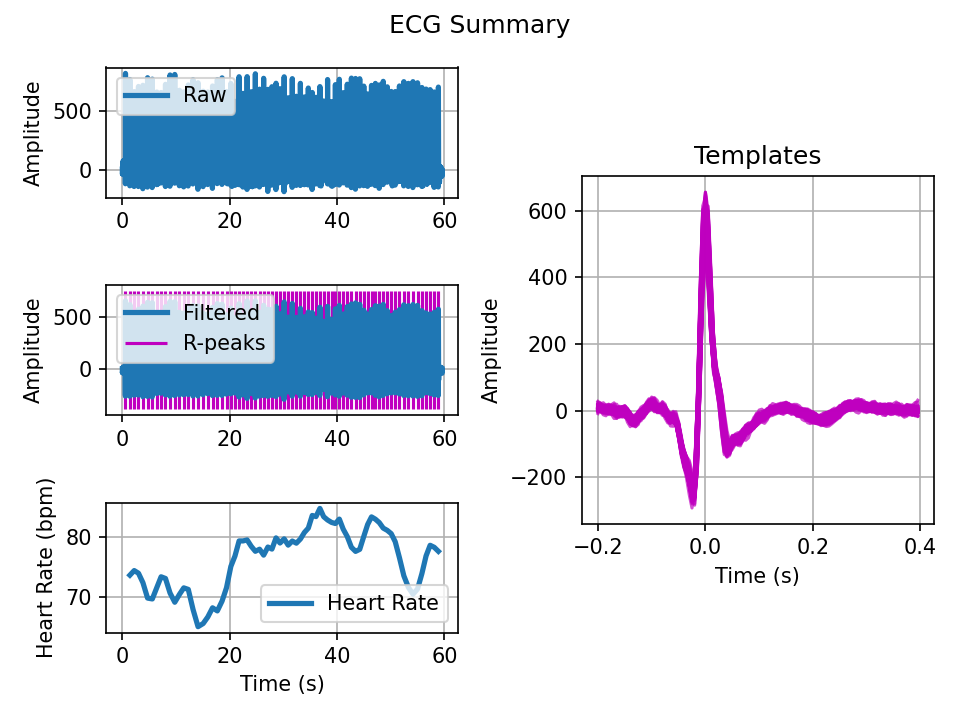

<IPython.core.display.Javascript object>


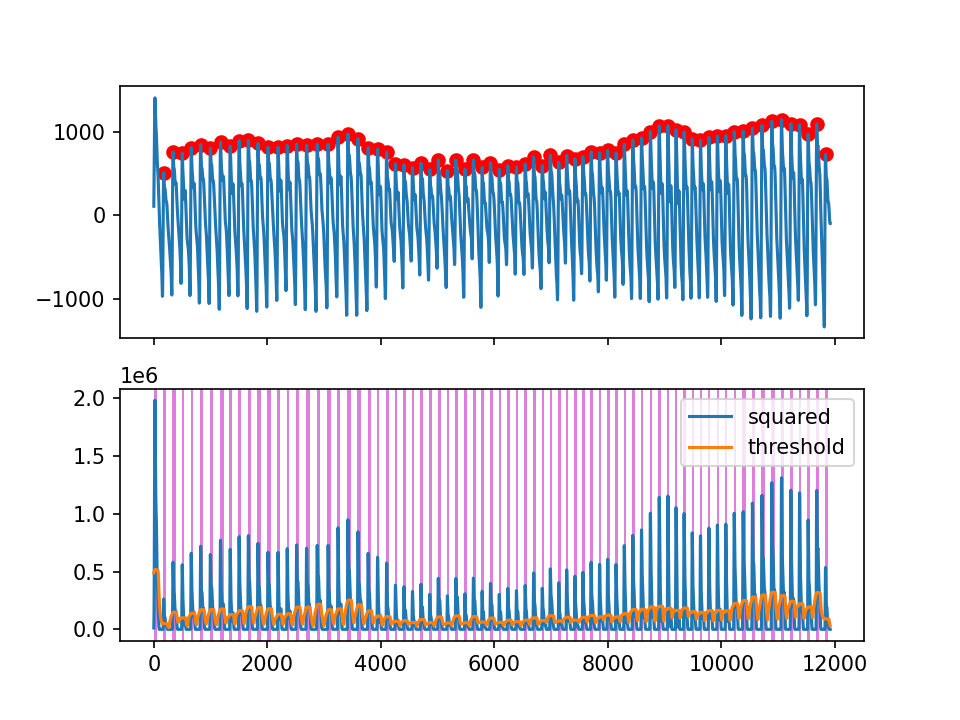

<IPython.core.display.Javascript object>


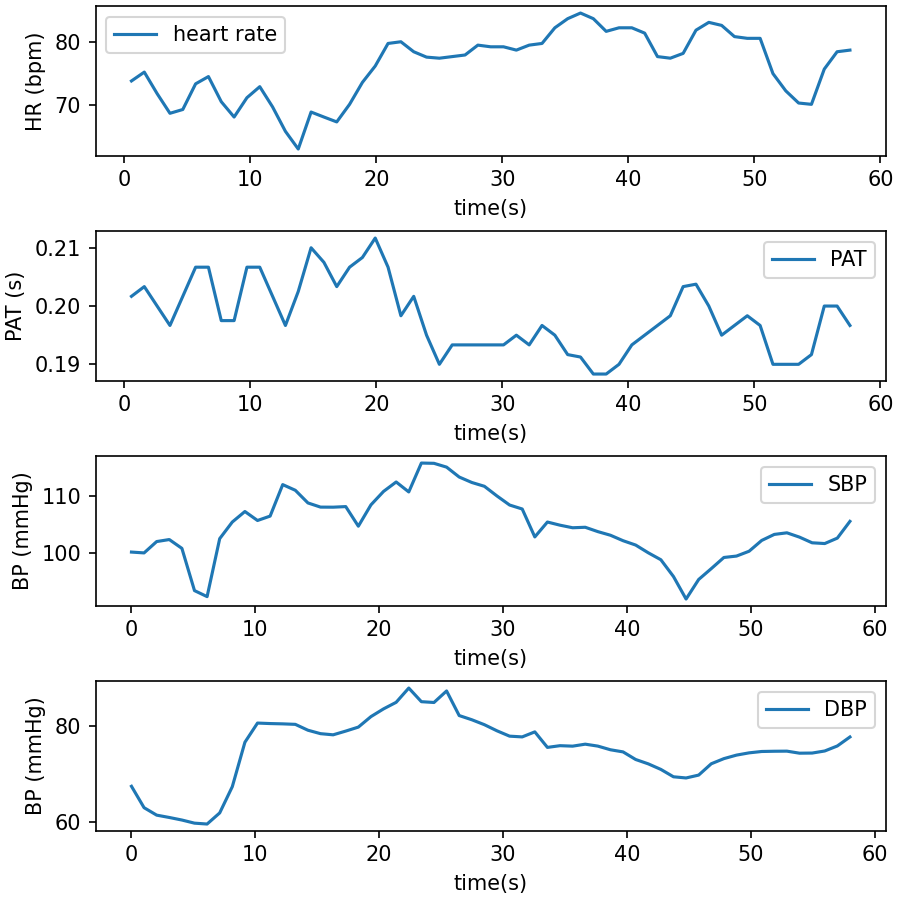

In [50]:
#1746
path_wav =  '../carlos_ref_29/2022-02-09-17-46-15/CNAP_2022-02-09_18-43-01_001_waveform.csv'
path_bet =  '../carlos_ref_29/2022-02-09-17-46-15/CNAP_2022-02-09_18-43-01_001_beats.csv'
path_sen = '../carlos_ref_29/2022-02-09-17-46-15/2022-02-09-17-46-15.csv'

abp = abp_sig(path_bet, path_wav)
ecg_f, ppg_f = ecg_ppg_show(path_sen)
ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd = ppg_features(ppg_f)
hr_lis = ecg_features(ecg_f)
pat_mx, pat_pk, pat_ft = pat_features(ecg_f, ppg_f)
sbp_lis, dbp_lis = sbp_dbp(abp)
visualize(ecg_f, hr_lis, pat_ft, sbp_lis, dbp_lis)

In [ ]:
#exclude, problem with calibration of ref device
df_1746 = pd.DataFrame({'hr':hr_lis, 'pat':pat_lis, 'sbp':sbp_lis[-22:], 'dbp':dbp_lis[-22:]})
df_1746

In [ ]:
df_1746.to_csv("../c_prepared_data/1746_all.csv", index = False)

<IPython.core.display.Javascript object>


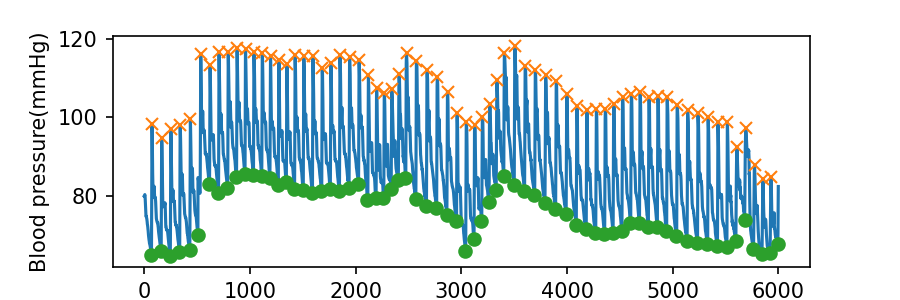

<IPython.core.display.Javascript object>


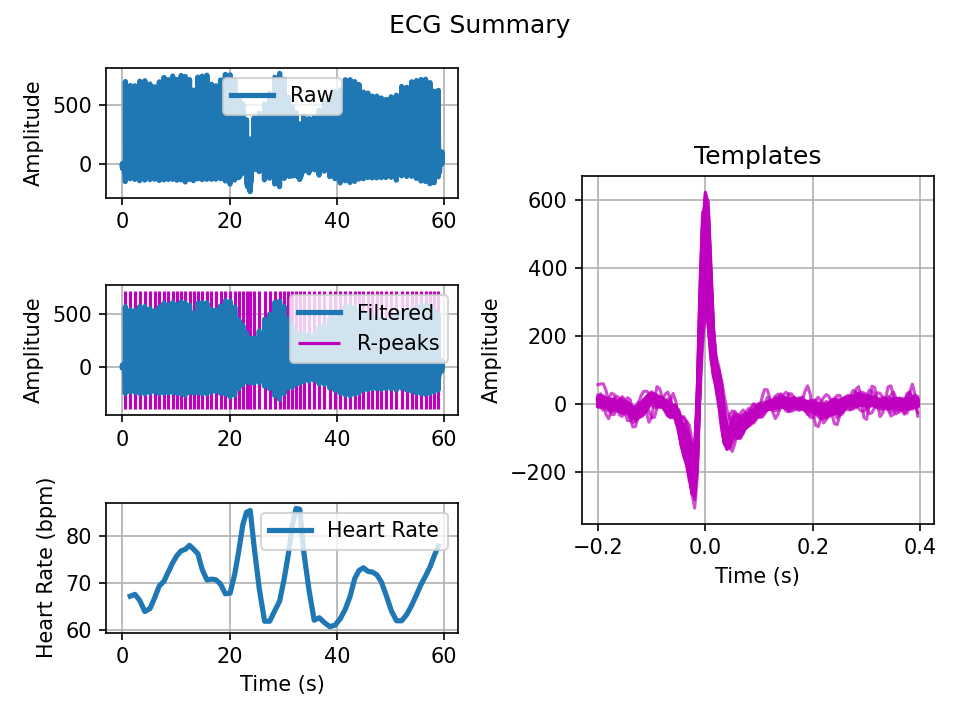

<IPython.core.display.Javascript object>


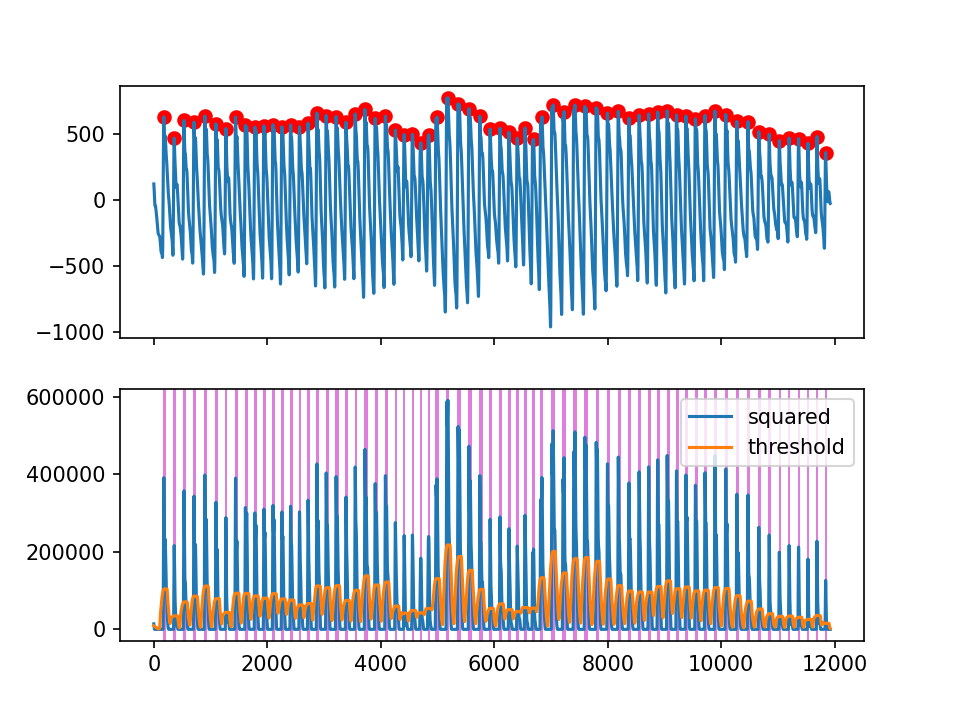

<IPython.core.display.Javascript object>


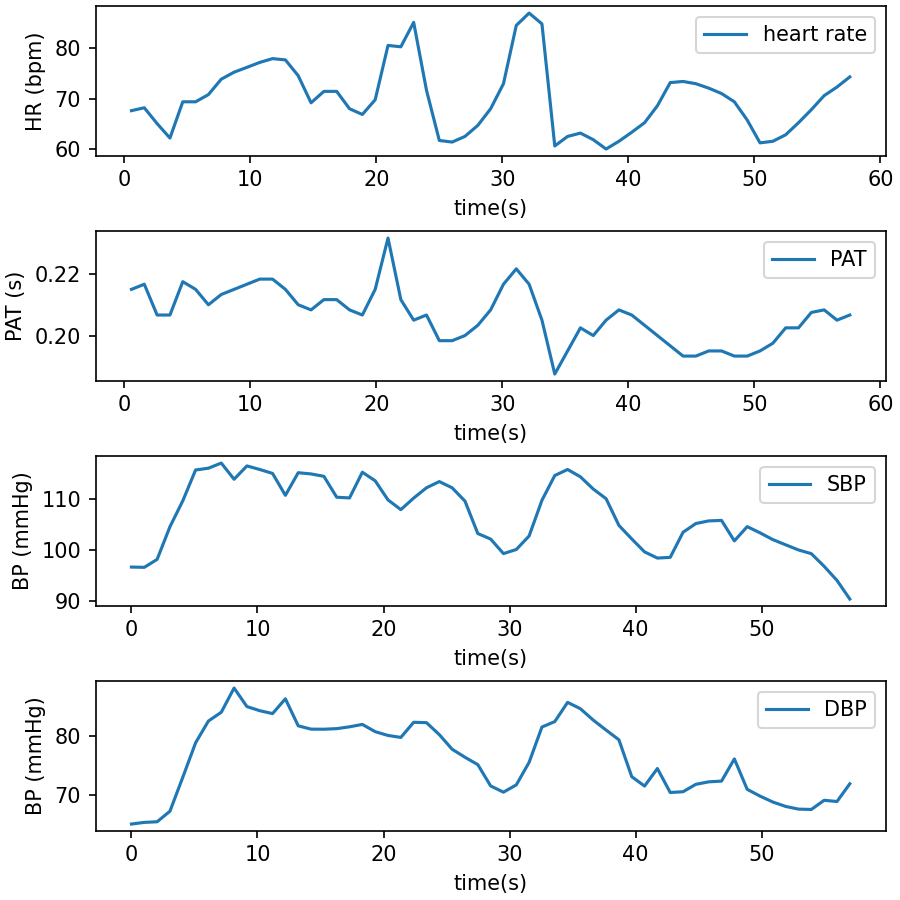

In [51]:
#1754

path_wav =  '../carlos_ref_29/2022-02-09-17-54-39/CNAP_2022-02-09_18-51-55_001_waveform.csv'
path_bet =  '../carlos_ref_29/2022-02-09-17-54-39/CNAP_2022-02-09_18-51-55_001_beats.csv'
path_sen = '../carlos_ref_29/2022-02-09-17-54-39/2022-02-09-17-54-39.csv'

abp = abp_sig(path_bet, path_wav)
ecg_f, ppg_f = ecg_ppg_show(path_sen)
ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd = ppg_features(ppg_f)
hr_lis = ecg_features(ecg_f)
pat_mx, pat_pk, pat_ft = pat_features(ecg_f, ppg_f)
sbp_lis, dbp_lis = sbp_dbp(abp)
visualize(ecg_f, hr_lis, pat_ft, sbp_lis, dbp_lis)

In [28]:
print(len(sbp_lis), len(pat_pk))

57 57


In [29]:
df_1754 = pd.DataFrame({'mxamp':ppg_maxamp[2:], 'std':ppg_std[2:], 'skew':ppg_skew[2:], 'kurtosis':ppg_kurto[2:], 'aimean':ppg_aimean[2:], 'lasimean':ppg_lasimean[2:], 'aistd':ppg_aistd[2:], 'lasistd':ppg_lasistd[2:],'hr':hr_lis[2:], 'patmx':pat_mx[2:], 'patpk':pat_pk[2:], 'patft':pat_ft[2:], 'sbp':sbp_lis[-55:], 'dbp':dbp_lis[-55:]})
df_1754

mxamp         std      skew  kurtosis    aimean  lasimean     aistd  \
0   1192.900858  323.576299 -0.184310 -1.149187  0.687681  0.060000  0.036085   
1   1192.900858  339.432634 -0.187815 -1.239822  0.738923  0.060000  0.015157   
2   1192.900858  324.194376 -0.306513 -1.101659  0.748644  0.057500  0.005436   
3   1203.866910  325.383586 -0.321261 -1.113743  0.663641  0.057500  0.079567   
4   1223.268210  348.023151 -0.213124 -1.267128  0.654774  0.057500  0.070701   
5   1223.268210  373.072958  0.065463 -1.429831  0.853804  0.047500  0.023247   
6   1164.263523  363.970806  0.080258 -1.370770  0.881014  0.042500  0.003963   
7   1202.427021  364.394647 -0.078198 -1.365427  0.887405  0.042500  0.002427   
8   1202.427021  367.559126 -0.072897 -1.406846  0.873581  0.045000  0.016328   
9   1214.068900  349.053664  0.024857 -1.314277  0.832337  0.047500  0.018912   
10  1304.957199  356.823642  0.016872 -1.293150  0.617936  0.102500  0.195490   
11  1319.986187  380.843111 -0.121323 -1.245154  0.605254  0.102500  0.182808   
12  1319.986187  414.193218 -0.082751 -1.447558  0.796036  0.047500  0.007973   
13  1313.771779  400.974268  0.118001 -1.385544  0.642238  0.105000  0.191007   
14  1418.934862  393.578175  0.221366 -1.254019  0.640378  0.105000  0.189146   
15  1418.934862  399.613715  0.158332 -1.222538  0.835903  0.047500  0.006379   
16  1418.934862  412.606003  0.011773 -1.307977  0.831059  0.047500  0.011223   
17  1337.314660  384.462301 -0.110022 -1.241672  0.844142  0.047500  0.024306   
18  1293.364917  350.121054  0.014219 -1.208442  0.500733  0.113333  0.273870   
19  1164.134965  303.083131  0.024279 -1.140518  0.297404  0.140000  0.085871   
20  1270.583421  332.086214  0.037891 -1.070761  0.415991  0.122500  0.032715   
21  1617.294154  418.710976 -0.049050 -1.005455  0.408791  0.112500  0.039915   
22  1617.294154  488.723891  0.061066 -1.341816  0.674899  0.085000  0.000000   
23  1617.294154  505.981709  0.079791 -1.403989  0.809597  0.060000  0.098325   
24  1541.211389  469.538261  0.141450 -1.376120  0.854347  0.045000  0.053574   
25  1466.292684  394.570154  0.202321 -1.105066  0.791129  0.050000  0.009644   
26  1360.207090  331.428533  0.078670 -1.025549  0.740604  0.052500  0.040881   
27  1046.467207  292.573723 -0.205052 -1.169973  0.742880  0.052500  0.043156   
28  1049.955079  304.473228 -0.055287 -1.254798  0.508174  0.121667  0.200082   
29  1221.344789  333.069314  0.028072 -1.221705  0.362897  0.152500  0.052649   
30  1586.948402  401.495975  0.278719 -0.960030  0.371086  0.122500  0.060839   
31  1677.027334  463.630868  0.044304 -1.225239  0.554031  0.085000  0.122105   
32  1677.027334  496.070554  0.219606 -1.295964  0.730186  0.080000  0.000000   
33  1582.950734  501.800187  0.201441 -1.346379  0.655657  0.075000  0.000000   
34  1578.913501  499.027684  0.147495 -1.379324  0.747232  0.075000  0.000000   
35  1578.913501  493.220092  0.094393 -1.405766  0.913081  0.045000  0.000000   
36  1519.956117  460.074382  0.074893 -1.394057  0.918421  0.040000  0.000000   
37  1369.949442  421.632629  0.065980 -1.410405  0.860000  0.045000  0.000000   
38  1320.222073  389.311924  0.104342 -1.386966  0.783729  0.055000  0.024380   
39  1277.148632  369.969528  0.090703 -1.312924  0.810868  0.052500  0.002758   
40  1308.238752  376.706069 -0.062117 -1.303466  0.797738  0.052500  0.015887   
41  1373.927322  406.635195 -0.168567 -1.301106  0.798818  0.052500  0.016967   
42  1373.927322  431.457649 -0.104225 -1.457758  0.815289  0.050000  0.000495   
43  1373.927322  428.164587  0.095085 -1.454756  0.843104  0.050000  0.010674   
44  1276.719756  392.577325  0.123992 -1.350922  0.851475  0.050000  0.002302   
45  1282.652290  373.084481 -0.037338 -1.299840  0.845190  0.050000  0.003983   
46  1282.386164  363.275444 -0.216747 -1.222143  0.797295  0.052500  0.043911   
47  1257.341765  353.263269 -0.270054 -1.259292  0.774063  0.052500  0.020680   
48  1170.705251  329.946682 -0.292084 -1.

In [ ]:
df_1754.to_csv("../c_prepared_data/1754_all.csv", index = False)

<IPython.core.display.Javascript object>


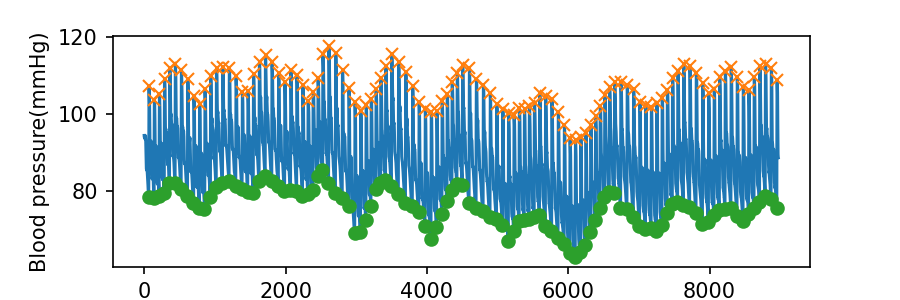

<IPython.core.display.Javascript object>


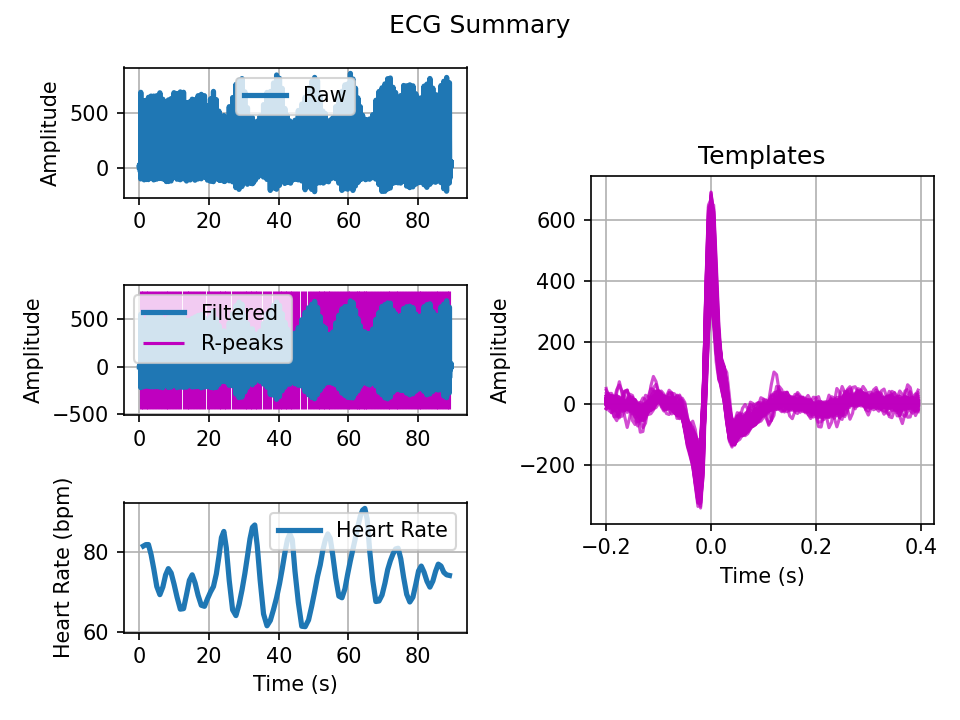

<IPython.core.display.Javascript object>


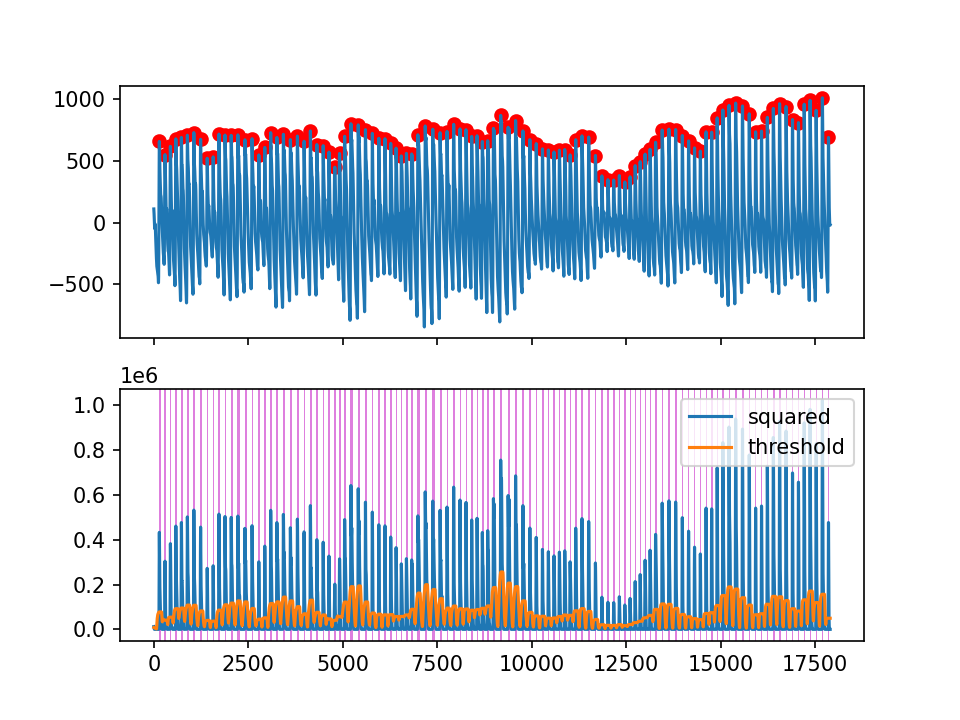

<IPython.core.display.Javascript object>


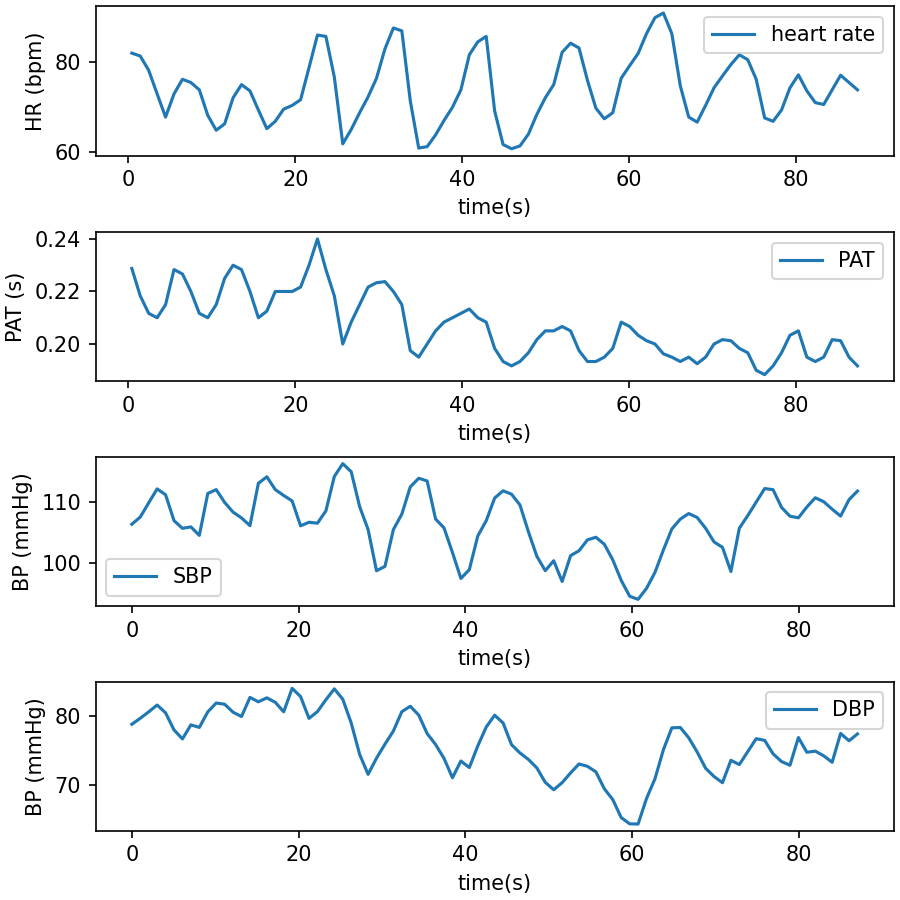

87 87


In [52]:
#1804
path_wav =  '../carlos_ref_29/2022-02-09-18-04-18/CNAP_2022-02-09_19-01-28_001_waveform.csv'
path_bet =  '../carlos_ref_29/2022-02-09-18-04-18/CNAP_2022-02-09_19-01-28_001_beats.csv'
path_sen = '../carlos_ref_29/2022-02-09-18-04-18/2022-02-09-18-04-18.csv'

abp = abp_sig(path_bet, path_wav)
ecg_f, ppg_f = ecg_ppg_show(path_sen)
ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd = ppg_features(ppg_f)
hr_lis = ecg_features(ecg_f)
pat_mx, pat_pk, pat_ft = pat_features(ecg_f, ppg_f)
sbp_lis, dbp_lis = sbp_dbp(abp)
visualize(ecg_f, hr_lis, pat_ft, sbp_lis, dbp_lis)
print(len(sbp_lis), len(pat_pk))

In [31]:
print(len(pat_pk),len(sbp_lis))

87 87


In [32]:
df_1804 = pd.DataFrame({'mxamp':ppg_maxamp, 'std':ppg_std, 'skew':ppg_skew, 'kurtosis':ppg_kurto, 'aimean':ppg_aimean, 'lasimean':ppg_lasimean, 'aistd':ppg_aistd, 'lasistd':ppg_lasistd,'hr':hr_lis, 'patmx':pat_mx, 'patpk':pat_pk, 'patft':pat_ft, 'sbp':sbp_lis[-87:], 'dbp':dbp_lis[-87:]})
df_1804

mxamp         std      skew  kurtosis    aimean  lasimean     aistd  \
0   1189.020091  311.525508 -0.473030 -0.756840  0.450328    0.0975  0.289872   
1   1321.747690  330.602995 -0.183114 -0.958143  0.361533    0.1150  0.292553   
2   1358.053065  377.250695 -0.102436 -1.245379  0.749686    0.0500  0.025526   
3   1379.192234  383.686353 -0.124032 -1.267909  0.743096    0.0500  0.018936   
4   1379.192234  364.972776 -0.376226 -1.066666  0.746623    0.0500  0.015408   
..          ...         ...       ...       ...       ...       ...       ...   
82  1538.010767  389.862586 -0.614775 -0.574210  0.642024    0.0575  0.020349   
83  1464.179032  347.921669 -0.930458  0.145228  0.587763    0.0600  0.033912   
84  1620.510527  404.037764 -0.755177 -0.458685  0.566109    0.0600  0.054546   
85  1624.427933  426.437826 -0.565449 -0.712164  0.674900    0.0550  0.036707   
86  1644.813847  436.832641 -0.509304 -0.776857  0.671991    0.0550  0.039616   

     lasistd         hr     patmx     patpk     patft         sbp        dbp  
0   0.047500  82.004556  0.292500  0.348333  0.228750  106.415000  78.837500  
1   0.046007  81.355932  0.280000  1.110000  0.218333  107.595000  79.707500  
2   0.000000  78.175896  0.273333  1.860000  0.211667  109.917500  80.647500  
3   0.000000  72.948328  0.270000  1.970000  0.210000  112.196667  81.633333  
4   0.000000  67.796610  0.275000  1.220000  0.215000  111.233333  80.500000  
..       ...        ...       ...       ...       ...         ...        ...  
82  0.002500  70.588235  0.256667  2.015000  0.195000  110.107500  74.250000  
83  0.000000  73.846154  0.263333  1.945000  0.201667  108.880000  73.313333  
84  0.004082  77.087794  0.262500  1.862500  0.201250  107.746667  77.507500  
85  0.000000  75.471698  0.255000  1.180000  0.195000  110.440000  76.437500  
86  0.000000  73.846154  0.253333  1.930000  0.191667  111.840000  77.432500  

[87 rows x 14 columns]

In [ ]:
df_1804.to_csv("../c_prepared_data/1804_all.csv", index = False)

<IPython.core.display.Javascript object>


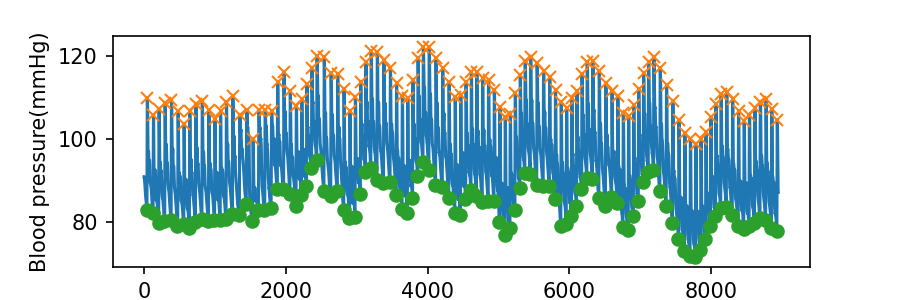

<IPython.core.display.Javascript object>


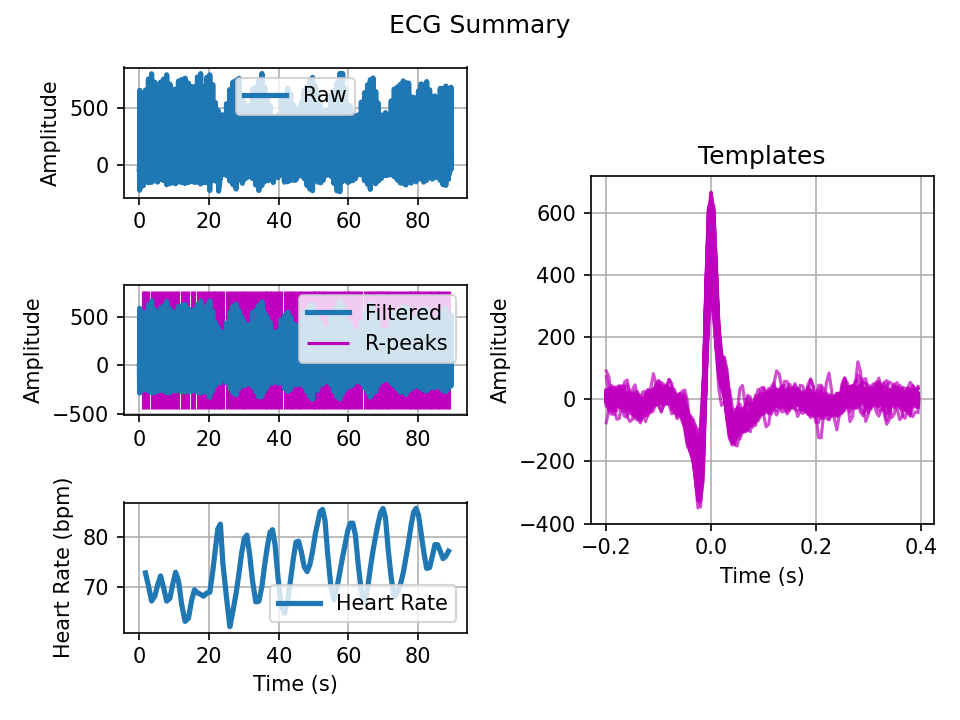

<IPython.core.display.Javascript object>


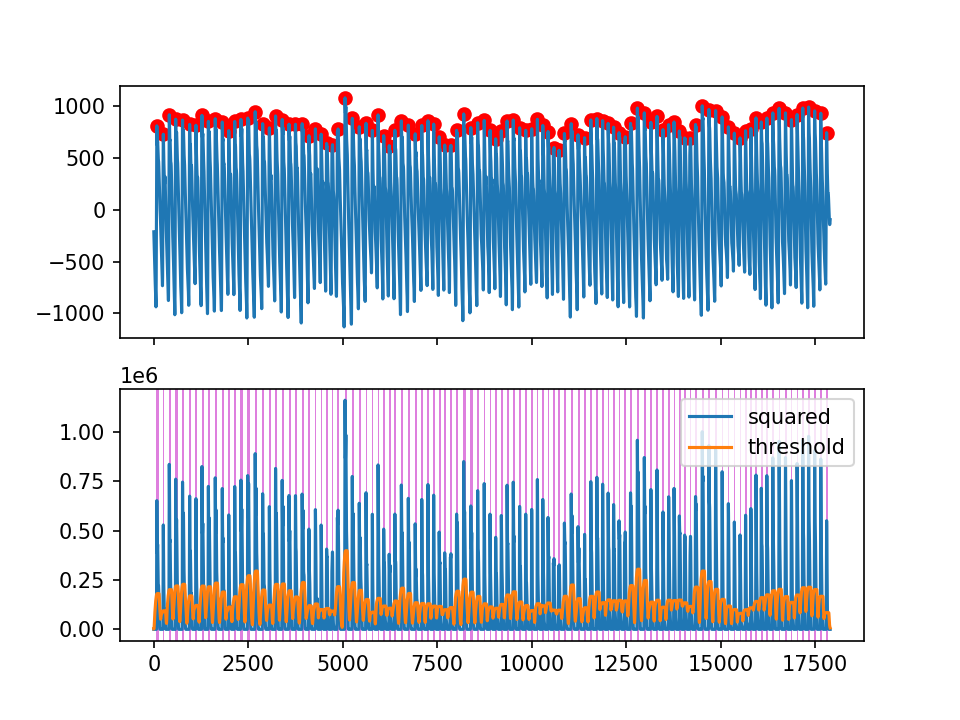

<IPython.core.display.Javascript object>


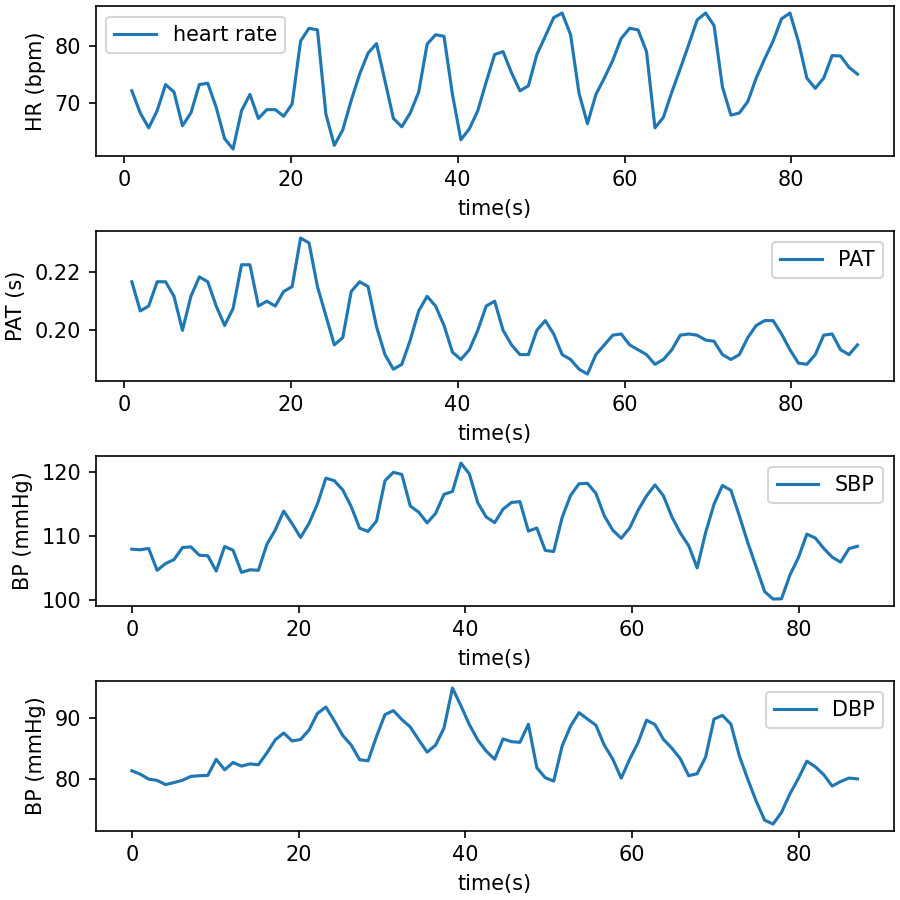

87 87


In [53]:
#181129
path_wav =  '../carlos_ref_29/2022-02-09-18-11-32/CNAP_2022-02-09_19-08-27_001_waveform.csv'
path_bet =  '../carlos_ref_29/2022-02-09-18-11-32/CNAP_2022-02-09_19-08-27_001_beats.csv'
path_sen = '../carlos_ref_29/2022-02-09-18-11-32/2022-02-09-18-11-32.csv'

abp = abp_sig(path_bet, path_wav)
ecg_f, ppg_f = ecg_ppg_show(path_sen)
ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd = ppg_features(ppg_f)
hr_lis = ecg_features(ecg_f)
pat_mx, pat_pk, pat_ft = pat_features(ecg_f, ppg_f)
sbp_lis, dbp_lis = sbp_dbp(abp)
visualize(ecg_f, hr_lis, pat_ft, sbp_lis, dbp_lis)
print(len(sbp_lis), len(pat_pk))

In [34]:
df_181129 = pd.DataFrame({'mxamp':ppg_maxamp, 'std':ppg_std, 'skew':ppg_skew, 'kurtosis':ppg_kurto, 'aimean':ppg_aimean, 'lasimean':ppg_lasimean, 'aistd':ppg_aistd, 'lasistd':ppg_lasistd,'hr':hr_lis, 'patmx':pat_mx, 'patpk':pat_pk, 'patft':pat_ft, 'sbp':sbp_lis[-87:], 'dbp':dbp_lis[-87:]})
df_181129

mxamp         std      skew  kurtosis    aimean  lasimean     aistd  \
0   1927.188127  538.144567  0.022529 -1.297479  0.565918  0.097500  0.223980   
1   1927.188127  566.926069  0.093084 -1.362503  0.752557  0.055000  0.000000   
2   1927.188127  576.559503  0.302254 -1.311564  0.783617  0.050000  0.005686   
3   1857.453208  516.240773  0.236320 -1.168878  0.788149  0.047500  0.001154   
4   1833.106311  506.285467  0.062771 -1.240368  0.759950  0.047500  0.027046   
..          ...         ...       ...       ...       ...       ...       ...   
82  1874.386682  506.819392 -0.141387 -1.215751  0.583513  0.102500  0.198989   
83  1880.628836  527.228365 -0.204149 -1.216403  0.351472  0.152500  0.033052   
84  1934.225542  552.818758 -0.064354 -1.307452  0.638481  0.083333  0.226781   
85  1934.225542  568.988263  0.024566 -1.307345  0.787328  0.050000  0.006567   
86  1934.225542  539.497445 -0.158269 -1.234076  0.800187  0.050000  0.006292   

    lasistd         hr     patmx   patpk     patft         sbp        dbp  
0   0.05250  72.072072  0.275000  0.3350  0.216667  107.900000  81.297500  
1   0.00000  68.181818  0.266667  1.2900  0.206667  107.810000  80.745000  
2   0.00000  65.573770  0.268333  1.3425  0.208333  108.017500  79.920000  
3   0.00250  68.571429  0.276667  1.3450  0.216667  104.595000  79.716667  
4   0.00250  73.170732  0.278333  1.9650  0.216667  105.656667  79.020000  
..      ...        ...       ...     ...       ...         ...        ...  
82  0.05250  74.303406  0.263333  1.9500  0.198333  108.035000  80.665000  
83  0.00250  78.260870  0.263750  1.8650  0.198750  106.657500  78.776667  
84  0.04714  78.175896  0.258333  1.1475  0.193333  105.876667  79.525000  
85  0.00000  76.190476  0.255000  1.8900  0.191667  107.995000  80.095000  
86  0.00000  75.000000  0.258333  1.9250  0.195000  108.352500  79.962500  

[87 rows x 14 columns]

In [ ]:
df_181129.to_csv("../c_prepared_data/181129_all.csv", index = False)

<IPython.core.display.Javascript object>


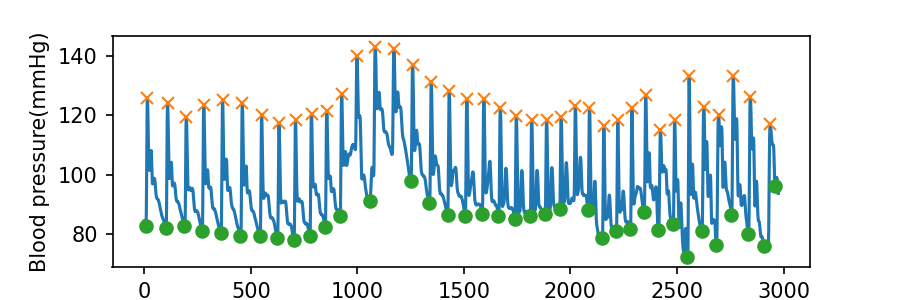

<IPython.core.display.Javascript object>


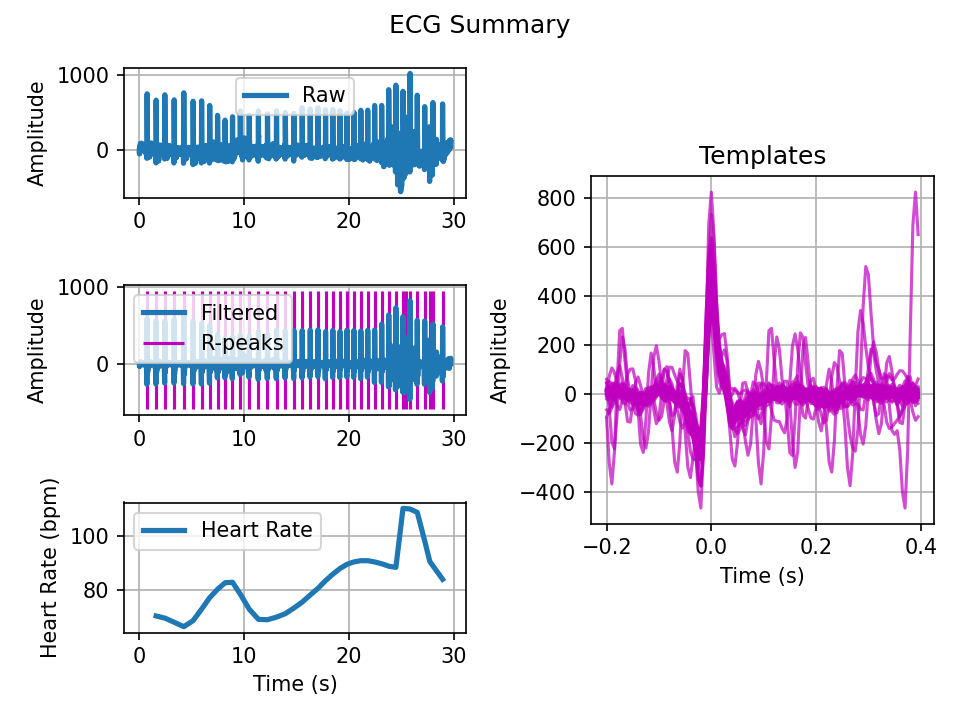

<IPython.core.display.Javascript object>


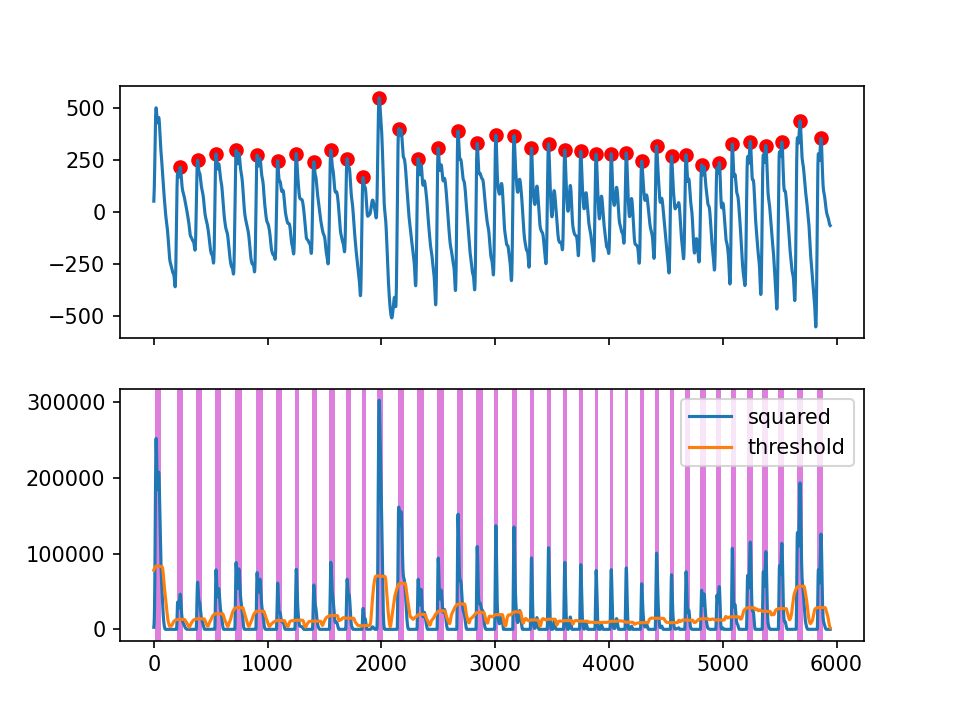

<IPython.core.display.Javascript object>


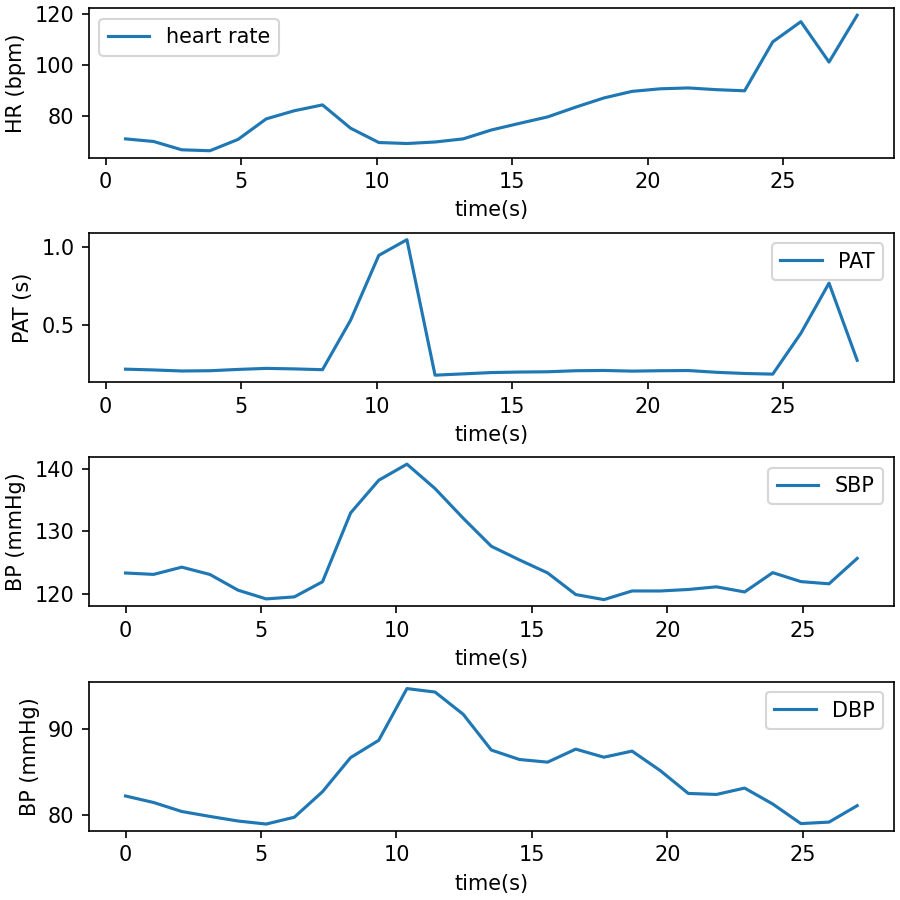

27 27


In [54]:
#182129
path_wav =  '../carlos_ref_29/2022-02-09-18-21-32/CNAP_2022-02-09_19-18-26_001_waveform.csv'
path_bet =  '../carlos_ref_29/2022-02-09-18-21-32/CNAP_2022-02-09_19-18-26_001_beats.csv'
path_sen = '../carlos_ref_29/2022-02-09-18-21-32/2022-02-09-18-21-32.csv'

abp = abp_sig(path_bet, path_wav)
ecg_f, ppg_f = ecg_ppg_show(path_sen)
ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd = ppg_features(ppg_f)
hr_lis = ecg_features(ecg_f)
pat_mx, pat_pk, pat_ft = pat_features(ecg_f, ppg_f)
sbp_lis, dbp_lis = sbp_dbp(abp)
visualize(ecg_f, hr_lis, pat_ft, sbp_lis, dbp_lis)
print(len(sbp_lis), len(pat_pk))

In [ ]:
#exclude. noisy ecg
df_182129 = pd.DataFrame({'mxamp':ppg_maxamp, 
                          'std':ppg_std, 'skew':ppg_skew, 
                          'kurtosis':ppg_kurto, 
                          'aimean':ppg_aimean, 
                          'lasimean':ppg_lasimean, 
                          'aistd':ppg_aistd, 
                          'lasistd':ppg_lasistd,
                          'hr':hr_lis, 
                          'patmx':pat_mx, 
                          'patpk':pat_pk, 
                          'patft':pat_ft, 
                          'sbp':sbp_lis[-87:], 
                          'dbp':dbp_lis[-87:]})
df_182129

In [ ]:
df_182129.to_csv("../c_prepared_data/182129_all.csv", index = False)

In [ ]:
#183829
path_wav =  '../carlos_ref_29/2022-02-09-18-38-59/CNAP_2022-02-09_19-35-52_001_waveform.csv'
path_bet =  '../carlos_ref_29/2022-02-09-18-38-59/CNAP_2022-02-09_19-35-52_001_beats.csv'
path_sen = '../carlos_ref_29/2022-02-09-18-38-59/2022-02-09-18-38-59.csv'

abp = abp_sig(path_bet, path_wav)
ecg_f, ppg_f = ecg_ppg_show(path_sen)
ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd = ppg_features(ppg_f)
hr_lis = ecg_features(ecg_f)
pat_mx, pat_pk, pat_ft = pat_features(ecg_f, ppg_f)
sbp_lis, dbp_lis = sbp_dbp(abp)
visualize(ecg_f, hr_lis, pat_ft, sbp_lis, dbp_lis)
print(len(sbp_lis), len(pat_pk))


In [ ]:
#exclude.noisy ecg and ppg
df_183829 = pd.DataFrame({'mxamp':ppg_maxamp, 
                          'std':ppg_std, 'skew':ppg_skew, 
                          'kurtosis':ppg_kurto, 
                          'aimean':ppg_aimean, 
                          'lasimean':ppg_lasimean, 
                          'aistd':ppg_aistd, 
                          'lasistd':ppg_lasistd,
                          'hr':hr_lis, 
                          'patmx':pat_mx, 
                          'patpk':pat_pk, 
                          'patft':pat_ft, 
                          'sbp':sbp_lis[-87:], 
                          'dbp':dbp_lis[-87:]})
df_183829

In [ ]:
df_183829.to_csv("183829_foot.csv", index = False)

<IPython.core.display.Javascript object>


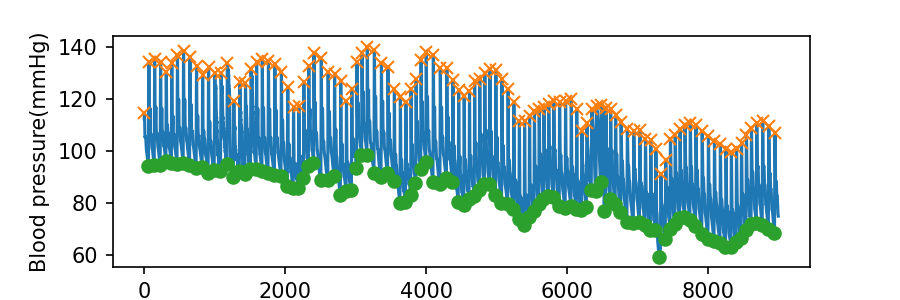

<IPython.core.display.Javascript object>


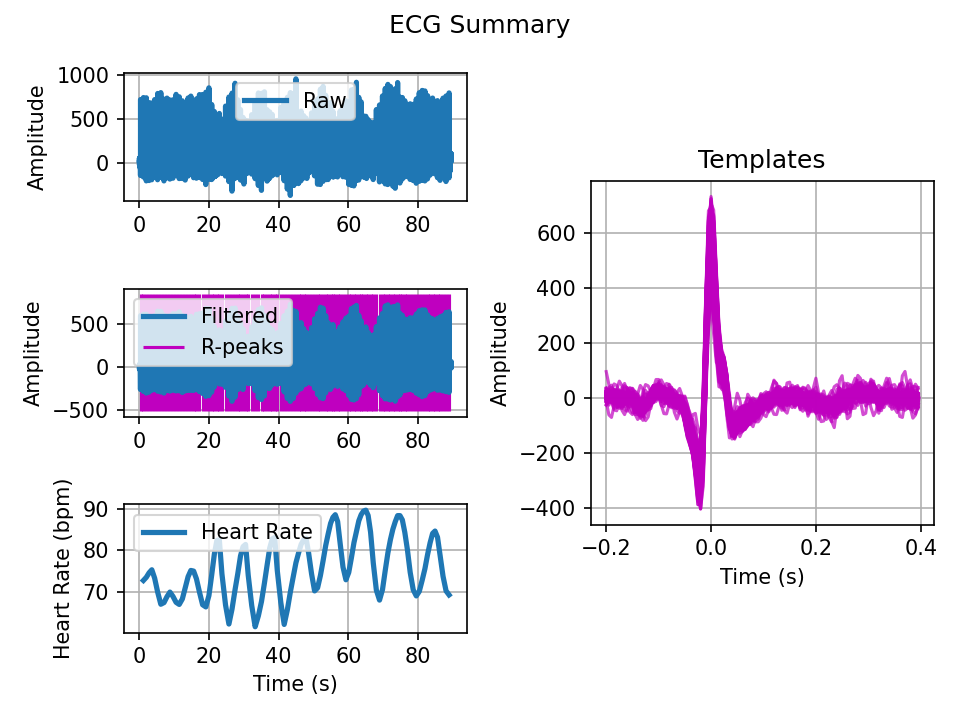

<IPython.core.display.Javascript object>


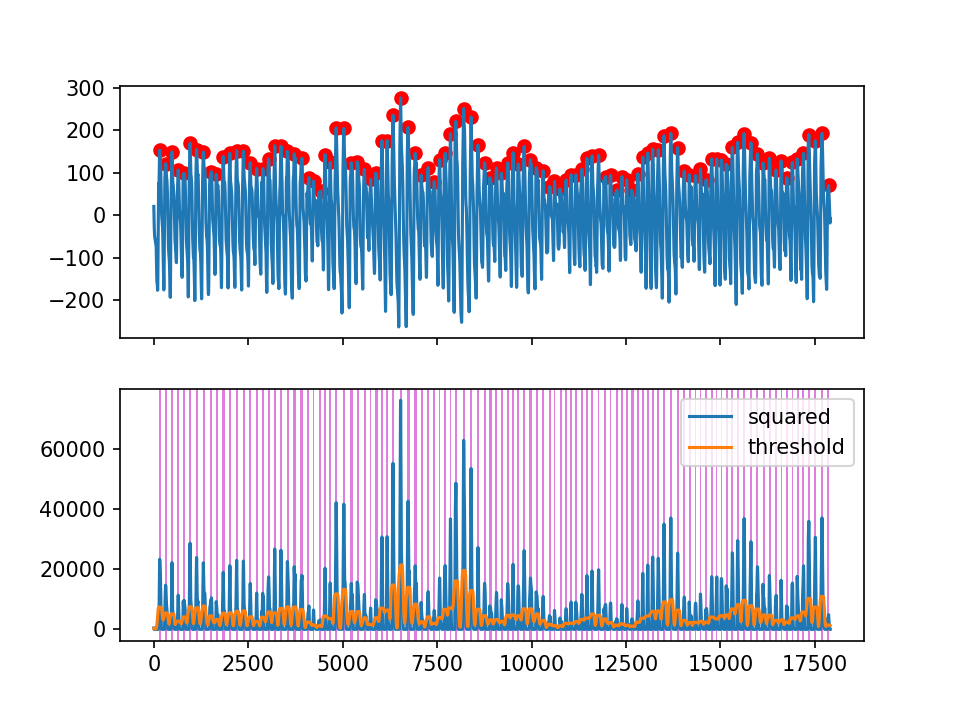

<IPython.core.display.Javascript object>


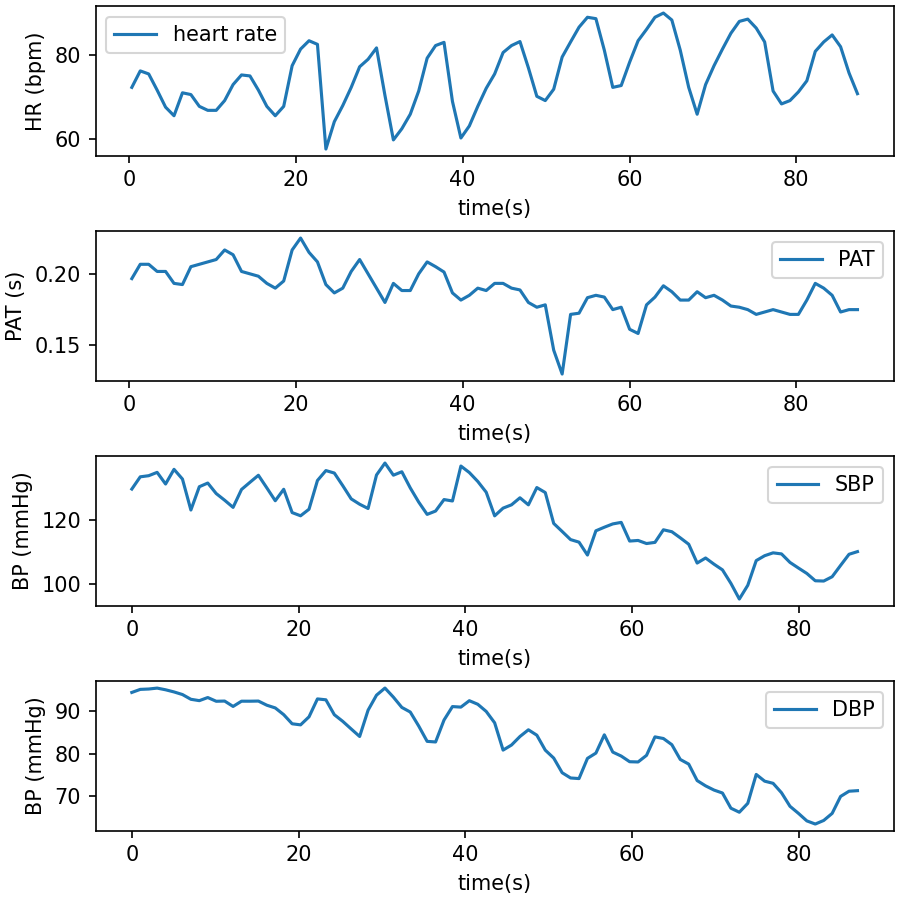

87 87


In [55]:
#185429
path_wav =  '../carlos_ref_29/2022-02-09-18-54-18/CNAP_2022-02-09_19-49-50_001_waveform.csv'
path_bet =  '../carlos_ref_29/2022-02-09-18-54-18/CNAP_2022-02-09_19-49-50_001_beats.csv'
path_sen = '../carlos_ref_29/2022-02-09-18-54-18/2022-02-09-18-54-18.csv'

abp = abp_sig(path_bet, path_wav)
ecg_f, ppg_f = ecg_ppg_show(path_sen)
ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd = ppg_features(ppg_f)
hr_lis = ecg_features(ecg_f)
pat_mx, pat_pk, pat_ft = pat_features(ecg_f, ppg_f)
sbp_lis, dbp_lis = sbp_dbp(abp)
visualize(ecg_f, hr_lis, pat_ft, sbp_lis, dbp_lis)
print(len(sbp_lis), len(pat_pk))

In [37]:
df_185429 = pd.DataFrame({'mxamp':ppg_maxamp, 
                          'std':ppg_std, 'skew':ppg_skew, 
                          'kurtosis':ppg_kurto, 
                          'aimean':ppg_aimean, 
                          'lasimean':ppg_lasimean, 
                          'aistd':ppg_aistd, 
                          'lasistd':ppg_lasistd,
                          'hr':hr_lis, 
                          'patmx':pat_mx, 
                          'patpk':pat_pk, 
                          'patft':pat_ft, 
                          'sbp':sbp_lis[-87:], 
                          'dbp':dbp_lis[-87:]})
df_185429

mxamp         std      skew  kurtosis    aimean  lasimean     aistd  \
0   345.498001   97.652860  0.048417 -1.196554 -0.144733    0.2725  0.277224   
1   341.751440   89.547245  0.248043 -1.124350  0.077077    0.2025  0.499034   
2   362.023538   94.828413  0.278621 -1.135086  0.136811    0.1650  0.378784   
3   369.690809   95.858247  0.398816 -1.024659  0.143913    0.1675  0.492229   
4   369.690809  103.923960  0.309710 -1.194753  0.677784    0.0725  0.041643   
..         ...         ...       ...       ...       ...       ...       ...   
82  280.924809   76.974487  0.060091 -1.210847  0.436532    0.1250  0.309072   
83  303.249129   85.742040  0.236107 -1.190659  0.579171    0.0750  0.281850   
84  385.590239  100.699059  0.080688 -1.141817  0.156118    0.1750  0.361026   
85  392.598289  110.293092  0.112247 -1.266855  0.180152    0.1575  0.519554   
86  395.691332  115.074385 -0.025350 -1.282341  0.518877    0.0950  0.180829   

     lasistd         hr     patmx   patpk     patft       sbp        dbp  
0   0.057500  72.289157  0.265000  0.4450  0.196667  129.6325  94.480000  
1   0.127500  76.190476  0.660000  1.2550  0.206667  133.4500  95.200000  
2   0.075609  75.471698  1.065000  1.2475  0.206667  133.7975  95.287500  
3   0.092500  71.641791  0.268333  1.3800  0.201667  134.8400  95.502500  
4   0.002500  67.605634  0.263333  2.2000  0.201667  131.2050  95.106667  
..       ...        ...       ...     ...       ...       ...        ...  
82  0.058878  83.044983  0.248333  1.1950  0.190000  100.9375  64.300000  
83  0.030000  84.705882  0.242500  1.7250  0.185000  102.2850  65.967500  
84  0.055227  81.911263  0.238333  1.1425  0.173333  105.8200  69.965000  
85  0.082500  75.709779  0.240000  2.0000  0.175000  109.2875  71.192500  
86  0.020000  70.796460  0.241667  2.1350  0.175000  110.1150  71.322500  

[87 rows x 14 columns]

In [ ]:
df_185429.to_csv("../c_prepared_data/185429_all.csv", index = False)

<IPython.core.display.Javascript object>


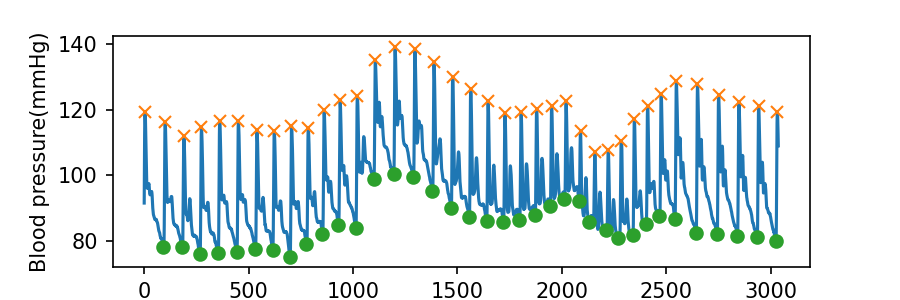

<IPython.core.display.Javascript object>


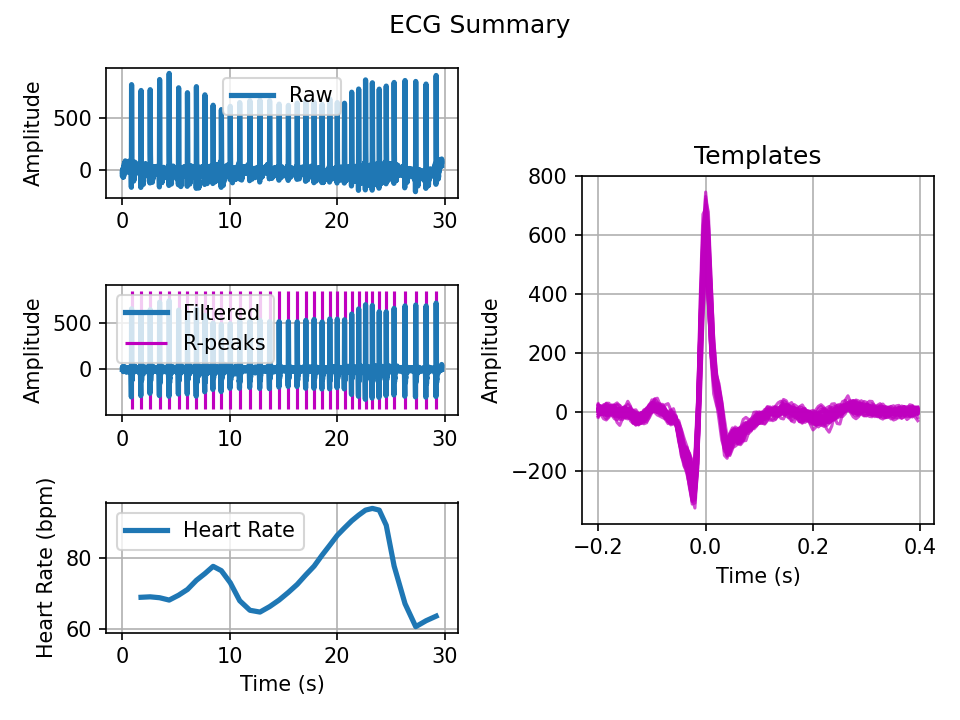

<IPython.core.display.Javascript object>


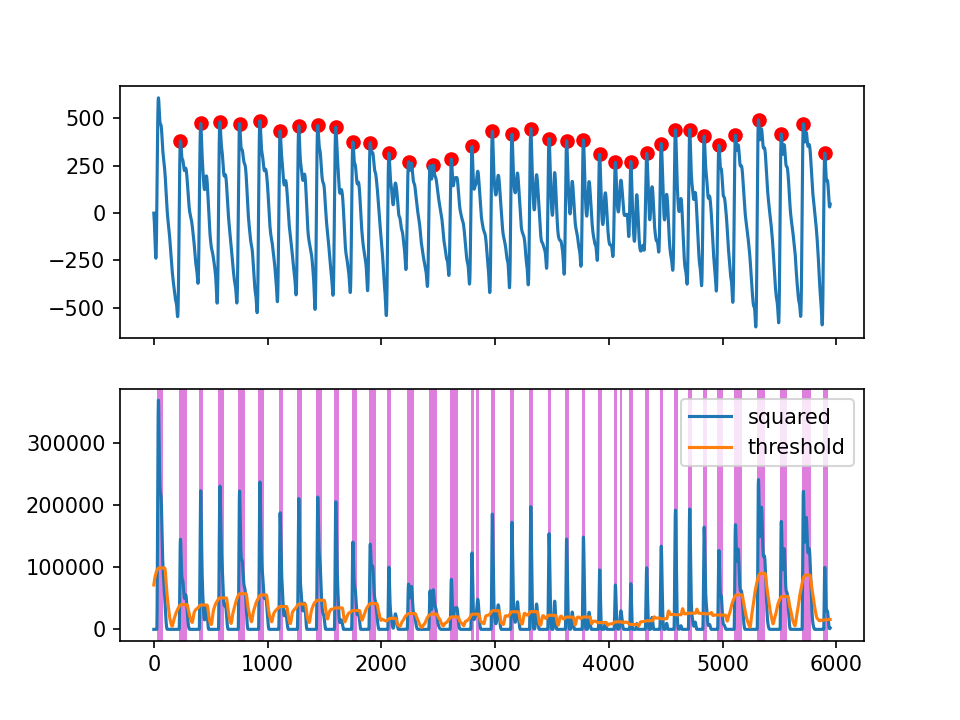

<IPython.core.display.Javascript object>


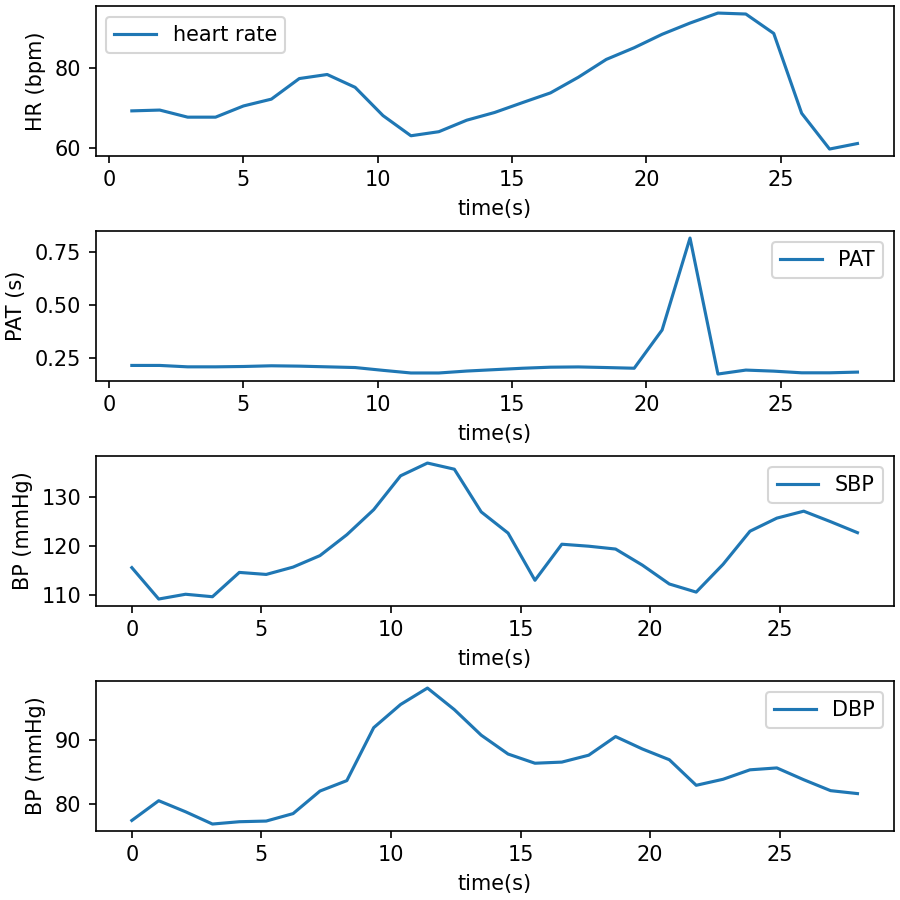

28 27


In [56]:

path_bet = '../carlos_ref_22/2022-02-02-18-34-31/CNAP_2022-02-02_19-31-44_001_beats.csv'
path_wav = '../carlos_ref_22/2022-02-02-18-34-31/CNAP_2022-02-02_19-31-44_001_waveform.csv'
path_sen = '../carlos_ref_22/2022-02-02-18-34-31/2022-02-02-18-34-31.csv'

abp = abp_sig(path_bet, path_wav)
ecg_f, ppg_f = ecg_ppg_show(path_sen)
ppg_maxamp, ppg_std, ppg_skew, ppg_kurto, ppg_aimean, ppg_lasimean, ppg_aistd, ppg_lasistd = ppg_features(ppg_f)
hr_lis = ecg_features(ecg_f)
pat_mx, pat_pk, pat_ft = pat_features(ecg_f, ppg_f)
sbp_lis, dbp_lis = sbp_dbp(abp)
visualize(ecg_f, hr_lis, pat_ft, sbp_lis, dbp_lis)
print(len(sbp_lis), len(pat_pk))

In [57]:
df_1834 = pd.DataFrame({'mxamp':ppg_maxamp, 
                          'std':ppg_std, 'skew':ppg_skew, 
                          'kurtosis':ppg_kurto, 
                          'aimean':ppg_aimean, 
                          'lasimean':ppg_lasimean, 
                          'aistd':ppg_aistd, 
                          'lasistd':ppg_lasistd,
                          'hr':hr_lis, 
                          'patmx':pat_mx, 
                          'patpk':pat_pk, 
                          'patft':pat_ft, 
                          'sbp':sbp_lis[-27:], 
                          'dbp':dbp_lis[-27:]})
df_1834

mxamp         std      skew  kurtosis    aimean  lasimean     aistd  \
0   1154.526305  290.838824  0.004436 -1.050061  0.798289  0.050000  0.000000   
1   1027.291020  276.269879  0.214252 -1.152092  0.341115  0.170000  0.079489   
2   1012.921936  284.298266  0.249104 -1.202212  0.590380  0.115000  0.169775   
3   1012.921936  270.768151  0.226234 -1.127640  0.750419  0.055000  0.009736   
4   1012.921936  258.330786  0.051606 -1.092774  0.545517  0.110000  0.195166   
5    970.074432  258.711570 -0.069420 -1.122298  0.503019  0.112500  0.152668   
6    970.074432  262.933453  0.052984 -1.248623  0.562670  0.093333  0.228620   
7    970.074432  254.874147  0.220596 -1.138662  0.503976  0.107500  0.255978   
8    994.609576  231.437768  0.353877 -0.809406  0.813578  0.047500  0.053624   
9    911.805525  216.391428  0.257561 -0.850552  0.503067  0.117500  0.364135   
10   857.534435  207.649194  0.338064 -0.928621  0.486734  0.122500  0.347801   
11   738.174733  197.977334  0.204397 -1.293382  0.816168  0.060000  0.000000   
12   850.388972  202.947345  0.294090 -0.973047  0.488848  0.065000  0.042157   
13   850.388972  203.347045  0.285555 -0.839375  0.475742  0.065000  0.029052   
14   864.103046  204.279882  0.177346 -0.715993  0.505585  0.065000  0.000791   
15   838.741152  193.709947 -0.158126 -0.768616  0.274265  0.112500  0.232111   
16   823.614346  191.155423 -0.298253 -0.725351  0.004687  0.156667  0.026613   
17   715.535811  172.234139 -0.388799 -0.641186 -0.022029  0.153333  0.011568   
18   708.379242  158.450773 -0.171449 -0.553498 -0.107962  0.152500  0.069969   
19   564.729031  138.040896 -0.214041 -0.751297 -0.217287  0.155000  0.237994   
20   740.238616  164.523083 -0.433025 -0.495753 -0.421618  0.220000  0.221162   
21   815.808601  184.384705 -0.329272 -0.421252 -0.064133  0.143333  0.059108   
22   852.063250  219.218622 -0.054187 -0.929614  0.267372  0.105000  0.312631   
23   911.450332  237.628050  0.231488 -1.018317  0.616212  0.060000  0.079541   
24  1092.114752  290.904141  0.299139 -1.134349  0.759168  0.055000  0.058416   
25  1092.114752  306.686720  0.323543 -1.153696  0.808078  0.052500  0.009506   
26  1092.114752  329.941016  0.225717 -1.333409  0.777099  0.052500  0.021473   

     lasistd         hr     patmx   patpk     patft         sbp        dbp  
0   0.000000  69.364162  0.273333  0.3350  0.213333  109.240000  80.490000  
1   0.005000  69.565217  0.271667  1.2400  0.213333  110.212500  78.745000  
2   0.060000  67.796610  0.265000  1.3250  0.206667  109.710000  76.813333  
3   0.000000  67.796610  0.266667  1.3850  0.206667  114.660000  77.176667  
4   0.055000  70.588235  0.270000  2.0300  0.208333  114.250000  77.282500  
5   0.052500  72.289157  0.273333  1.9900  0.211667  115.742500  78.457500  
6   0.050717  77.419355  0.271667  1.1050  0.210000  118.082500  82.013333  
7   0.057500  78.431373  0.268333  1.2125  0.206667  122.333333  83.660000  
8   0.002500  75.235110  0.261667  1.9100  0.203333  127.436667  92.007500  
9   0.072500  68.181818  0.245000  1.1800  0.190000  134.332500  95.660000  
10  0.067500  63.157895  0.232500  1.3800  0.177500  136.930000  98.253333  
11  0.000000  64.171123  0.235000  1.2300  0.177500  135.677500  94.853333  
12  0.000000  67.039106  0.245000  1.2025  0.186667  126.982500  90.823333  
13  0.000000  68.965517  0.251667  1.3075  0.193333  122.667500  87.850000  
14  0.000000  71.428571  0.256667  1.2825  0.200000  113.056000  86.400000  
15  0.047500  73.846154  0.078333  1.9450  0.205000  120.400000  86.577500  
16  0.002357  77.753780 -0.383750  1.8600  0.206250  119.997500  87.667500  
17  0.002357  82.191781 -0.143333  1.1650  0.203333  119.418000  90.602000  
18  0.002500  85.106383 -0.128333  1.7200  0.200000  116.132500  88.640000  
19  0.008165  88.452088  0.157500  1.6975  0.381667  112.302000  86.950000  
20  0.099750  91.254753 -0.080000  1.6500  0.818333  110.650000  82.920000  
21  0.008498  93.750000  0.270000  1.6300  0.17

In [ ]:
df_1834.to_csv("../c_prepared_data/1834_all.csv", index = False)

In [ ]:
df_1834.columns